In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
%env HDF5_USE_FILE_LOCKING=FALSE
    
import sys
sys.path.insert(1, '../../models/PFN')
from dataset_pfn import PFNDataset
from pfn_model import ParticleFlowNetwork as Model
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
import seaborn as sns
import os, json

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
#Training/Testing path
dataset=''
train_path = "../../datasets/train.h5"
val_path = "../../datasets/val.h5"
test_path = "../../datasets/test.h5"

In [3]:
test_set = PFNDataset(test_path, preprocessed = True)
test_data, test_mask, test_label, _ = test_set[:]

In [4]:
modelname = "../../models/PFN/trained_models/PFN_best"
model_dict = json.load(open(modelname.replace("trained_models/", "trained_model_dicts/").replace("_best", "") + ".json"))
phi_nodes = list(map(int, model_dict['phi_nodes'].split(',')))
f_nodes = list(map(int, model_dict['f_nodes'].split(',')))

model = Model(input_dims = 3, Phi_sizes=phi_nodes, F_sizes = f_nodes)
model.load_state_dict(torch.load(modelname))
model = model.cuda()
model.eval()

FcLayers = []
for layer in model._modules['fc']:
    FcLayers.append(layer)

In [5]:
def evalFC(model, data, mask_indices = [-1], mask_values = [0.]):
    lfs = data.cuda()
    for mask_index, mask_value in zip(mask_indices, mask_values):
        if mask_index >= 0:
            lfs[:, mask_index] = mask_value*torch.ones(lfs[:, mask_index].shape)  
    for ii, layer in enumerate(FcLayers):
        if ii == len(FcLayers)-1: 
            res = layer.forward(lfs).cpu()
        elif ii == len(FcLayers)-2:
            lfs = layer.forward(lfs)
            psmax = lfs.cpu()
        else:
            lfs = layer.forward(lfs)
    return psmax, res

def evalPHI(model, test_set, d_mean, mask_indices = []):
    myDL = DataLoader(test_set, batch_size=1024)
    with torch.no_grad():
        for idx, (d, m, l, _) in enumerate(myDL):
#             d_mean = d.mean(0)
#             print(d.shape, d_mean.shape)
            for mask_index in mask_indices:
#                 if mask_index >= 0:
#                 print(mask_index)
                try:
                    d[:, mask_index[0], mask_index[1]] = d_mean[mask_index[0], mask_index[1]]
                except:
                    d[:, mask_index[0], mask_index[1]] = d_mean[mask_index[1]]
            d2 = torch.flatten(d, start_dim=0, end_dim=1)
            lfs = model._modules['phi'].forward(d2.cuda())
            lfs = torch.stack(torch.split(lfs.permute(1, 0), 200, dim=1), 0)
            lfs = lfs * m.cuda().bool().float()
            lfs = lfs.sum(-1)
            this_lfs = lfs.cpu()  
            psmax, res = evalFC(model, lfs)
            # res = model._modules['fc'].forward(lfs)
            if idx == 0:
                latents = this_lfs.cpu()
                labels = l.cpu()
                presoftmax = psmax.cpu()
                preds = res.cpu()
            else:
                latents = torch.cat((latents, this_lfs.cpu()), 0)
                labels = torch.cat((labels, l.cpu()), 0)
                presoftmax  = torch.cat((presoftmax, psmax.cpu()), 0)
                preds  = torch.cat((preds, res.cpu()), 0)
            if idx == 100:
                break
    return latents, labels, presoftmax, preds

def getMeans(test_set, batch_size=1024):
    myDL = DataLoader(test_set, batch_size=batch_size)
    for idx, (d, m, l, _) in enumerate(myDL):
        if idx == 0:
            d_sum = d.cuda().sum(0)
            Ndata = torch.ones_like(d_sum)*m.cuda().transpose(2,1).sum(0)
        else:
            d_sum += d.cuda().sum(0)
            Ndata += torch.ones_like(d_sum)*m.cuda().transpose(2,1).sum(0)
    return (d_sum.cpu() + 1e-9)/(Ndata.cpu() + 1e-9)

In [6]:
def dAUC_chart(dAUC_vals, tags, tag, save=False):
    tag = "baseline" if tag == "" else tag.strip('_')
    dAUC_vals = dAUC_vals[::-1]
    tags = tags[::-1]
    pos = np.arange(len(dAUC_vals))
    figdim = int(len(tags)/2)
    plt.figure(figsize=(figdim, figdim))
    plt.barh(pos, dAUC_vals, align='center')
    plt.yticks(pos, tags, fontsize = figdim*2)
    plt.xlabel('Percent Drop in AUC', fontsize=figdim*2)
    plt.ylabel('Features', fontsize=figdim*2)
    plt.tick_params(axis='both', which='major', labelsize=figdim*2)
    plt.tight_layout()
    if save:
        plt.savefig("figures/dAUC_PFN_{}.png".format(tag))
    plt.show()

In [7]:
def removeOutliers(x, outlierConstant=1.5):
    quantiles = np.nanquantile(x, (0.25, 0.75),axis=0)
    IQR = (quantiles[1]-quantiles[0])*1.5
    result = np.where((x>=quantiles[0]-IQR)&(x<=quantiles[1]+IQR), x, 0)
    
    return result

def plotmaker(data, tags, plot_type = 'abs_bar', part_dataset = 'bkg', save = False, modelnamesuffix = ""):
    modelnamesuffix = 'baseline' if not modelnamesuffix else modelnamesuffix
    if plot_type == 'abs_bar':
        data_no_outlier = removeOutliers(data)
        plt.figure(figsize=(10,10))
        abs_data = np.nanmean(np.abs(data_no_outlier), 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=tags, rels=abs_data))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 20
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.tight_layout()
        plt.xlabel("MAD Relevance Score", fontsize=20)
        plt.ylabel("Features", fontsize=20)
        plt.tick_params(axis='both', which='major', labelsize=20)
        # plt.title("TopoDNN Absolute Value "+type_set+" Delta LRP values")
        if save:
            plt.savefig("figures/dLRP_PFN_{}_{}_absbar.png".format(modelnamesuffix, part_dataset), 
                        dpi = 150, bbox_inches='tight')
        plt.show()
    if plot_type == 'box_whisker':
        plt.figure(figsize=(10,10))
        df_rel_total = pd.DataFrame(removeOutliers(data), columns=tags)
        sorted_index = df_rel_total.abs().mean().sort_values(ascending=False).index
        df_rel = pd.DataFrame(data, columns=tags)
        df_rel_total = df_rel[sorted_index[:20]]
        sns.boxplot(data=df_rel_total, orient='h', showfliers=False)
        #plt.title("TopoDNN "+type_set+" LRP Box and Whisker Distribution")
        plt.tight_layout()
        if save:
            plt.savefig("figures/dLRP_PFN_{}_{}_boxwhisker.png".format(modelnamesuffix, part_dataset), 
                        dpi = 150, bbox_inches='tight')
        plt.show()

In [8]:
d_mean = getMeans(test_set)

In [9]:
baseline_latents, baseline_labels, baseline_presoftmax, baseline_preds = evalPHI(model, test_set, d_mean)
auc_baseline = roc_auc_score(baseline_labels[:, 0].numpy(), baseline_preds[:, 0].numpy())*100
print("Baseline model's AUC: {:.4f}%".format(auc_baseline))

Baseline model's AUC: 99.7387%


In [10]:
sig_indices = baseline_labels[:,0] == 0
bkg_indices = baseline_labels[:,0] == 1

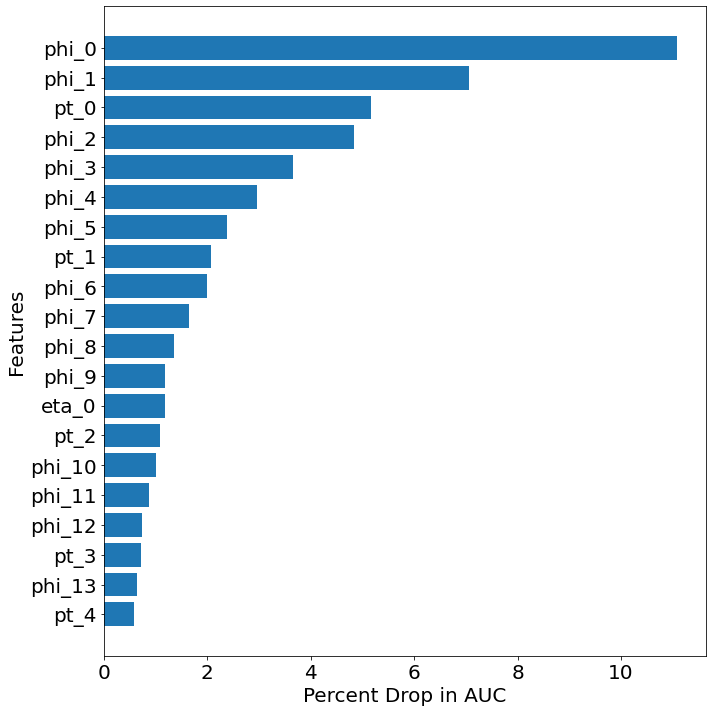

In [11]:
## Now finding dAUC and MAD-rel for original features

tags = []
dresult_presoftmax = []
dresult = []
dAUC_vals = []

for offset, feat_type in enumerate(['pt', 'eta', 'phi']):
    for const_id in range(30):
        tags.append(feat_type + '_' + str(const_id))
        mask_indices = [[const_id, offset]]
#         mask_indices = [offset]
        _, this_labels, this_presoftmax, this_preds = evalPHI(model, test_set, d_mean, mask_indices = mask_indices)
        dresult_presoftmax.append(((baseline_presoftmax - this_presoftmax)/baseline_presoftmax).cpu().numpy())
        dresult.append((baseline_preds - this_preds).cpu().numpy())
        this_auc = roc_auc_score(this_labels[:,0].numpy(), this_preds[:,0].numpy())*100
        dAUC_vals.append(auc_baseline - this_auc)

sorted_tags = []
sorted_vals = []
for val, tag in sorted(zip(dAUC_vals, tags), reverse = True)[:85]:
    sorted_tags.append(tag)
    sorted_vals.append(val)
dAUC_chart(sorted_vals[:20], sorted_tags[:20], tag = 'baseline_meaneach_ptetaphi', save = False)

In [12]:
dresult_presoftmax_bkg = []
dresult_presoftmax_sig = []
dresult_bkg = []
dresult_sig = []
for idx in range(len(tags)):
    dresult_presoftmax_bkg.append(dresult_presoftmax[idx][bkg_indices][:,0])
    dresult_presoftmax_sig.append(dresult_presoftmax[idx][sig_indices][:,1])
    dresult_bkg.append(dresult[idx][bkg_indices][:,0])
    dresult_sig.append(dresult[idx][sig_indices][:,1])

In [13]:
dresult_presoftmax_bkg = np.transpose(np.array(dresult_presoftmax_bkg))
dresult_presoftmax_sig = np.transpose(np.array(dresult_presoftmax_sig))
dresult_bkg = np.transpose(np.array(dresult_bkg))
dresult_sig = np.transpose(np.array(dresult_sig))

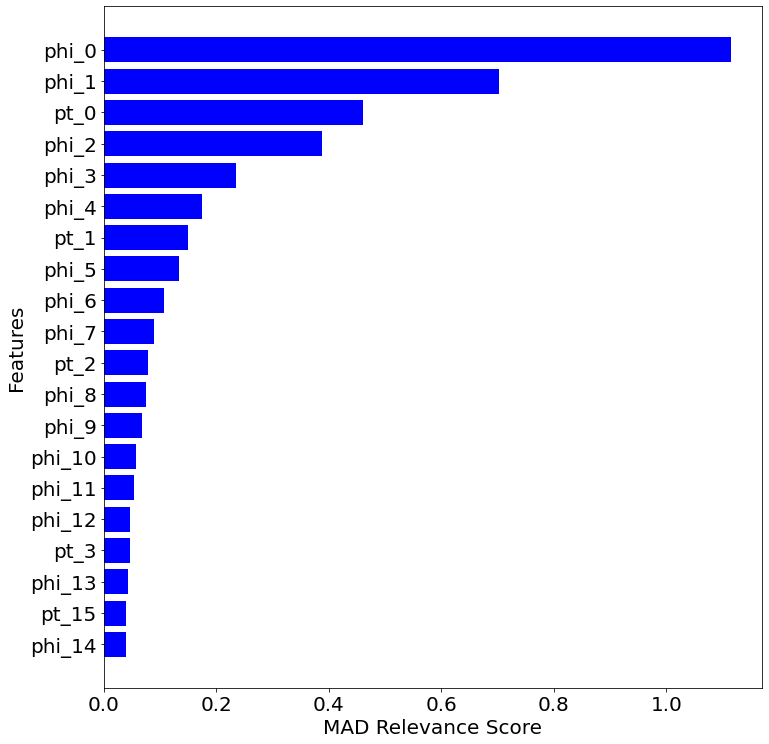

In [14]:
plotmaker(data = dresult_presoftmax_bkg, tags = tags, 
          plot_type = 'abs_bar', part_dataset = 'bkg', 
          save = False, modelnamesuffix = 'baseline__ptetaphi')

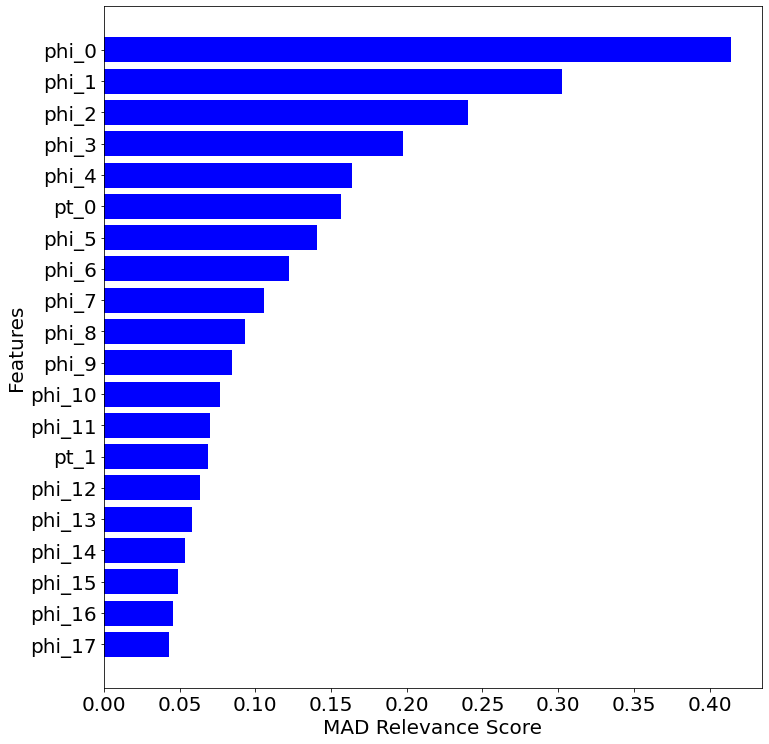

In [15]:
plotmaker(data = dresult_presoftmax_sig, tags = tags, 
          plot_type = 'abs_bar', part_dataset = 'sig', 
          save = False, modelnamesuffix = 'baseline_ptetaphi')

In [16]:
latent_means = baseline_latents.mean(0)

In [17]:
all_cols = ['z{}'.format(i) for i in range(256)]
tags = []
dresult_presoftmax = []
dresult = []
dAUC_vals = []
with torch.no_grad():
    for ii in range(latent_means.shape[0]):
        if latent_means[ii] < 0.1:
            continue
        this_presoftmax, this_preds = evalFC(model, baseline_latents, mask_indices = [ii], mask_values = [latent_means[ii]])
        tags.append('z' + str(ii))
        dresult_presoftmax.append(np.array(((baseline_presoftmax - this_presoftmax)/baseline_presoftmax).cpu().numpy()))
        dresult.append(np.array((baseline_preds - this_preds).cpu().numpy()))
        this_auc = roc_auc_score(baseline_labels[:,0].numpy(), this_preds[:,0].numpy())*100
        dAUC_vals.append(auc_baseline - this_auc)
                             
    

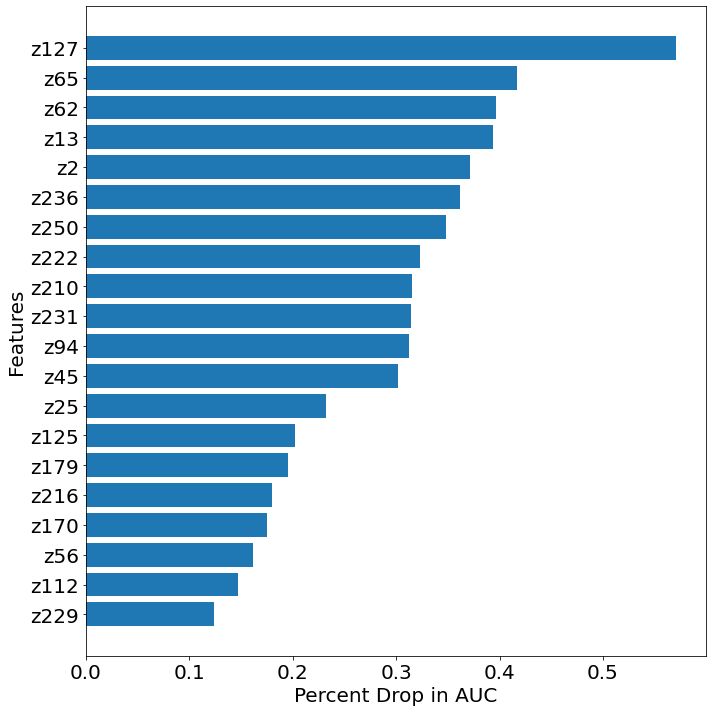

In [18]:
sorted_tags = []
sorted_vals = []
Nz = 85
for val, tag in sorted(zip(dAUC_vals, tags), reverse = True)[:Nz]:
    sorted_tags.append(tag)
    sorted_vals.append(val)
dAUC_chart(sorted_vals[:20], sorted_tags[:20], tag = 'baseline_z', save = False)

In [19]:
latents2explore = sorted_tags[:30]

In [20]:
mask_feats = [] # i for i in range(256)]
mask_values = [] # list(latent_means.numpy())

for ii, feat in enumerate(all_cols):
    if feat not in sorted_tags:
        mask_feats.append(int(feat.replace('z','')))
        mask_values.append(latent_means[ii])

with torch.no_grad():
    this_presoftmax, this_preds = evalFC(model, baseline_latents, 
                                         mask_indices = mask_feats, 
                                         mask_values = mask_values)
this_auc = roc_auc_score(baseline_labels[:,0].numpy(), this_preds[:,0].numpy())*100
print("Model AUC score with top {} feats only: {:.4f}%".format(Nz, this_auc))

Model AUC score with top 85 feats only: 98.8534%


In [21]:
df_sig = pd.DataFrame(baseline_latents[sig_indices], columns = all_cols).loc[:, sorted_tags]
df_bkg = pd.DataFrame(baseline_latents[bkg_indices], columns = all_cols).loc[:, sorted_tags]

In [22]:
dresult_presoftmax_bkg = []
dresult_presoftmax_sig = []
dresult_bkg = []
dresult_sig = []
for idx in range(len(tags)):
    dresult_presoftmax_bkg.append(dresult_presoftmax[idx][bkg_indices][:,0])
    dresult_presoftmax_sig.append(dresult_presoftmax[idx][sig_indices][:,1])
    dresult_bkg.append(dresult[idx][bkg_indices][:,0])
    dresult_sig.append(dresult[idx][sig_indices][:,1])

In [23]:
dresult_presoftmax_bkg = np.transpose(np.array(dresult_presoftmax_bkg))
dresult_presoftmax_sig = np.transpose(np.array(dresult_presoftmax_sig))
dresult_bkg = np.transpose(np.array(dresult_bkg))
dresult_sig = np.transpose(np.array(dresult_sig))

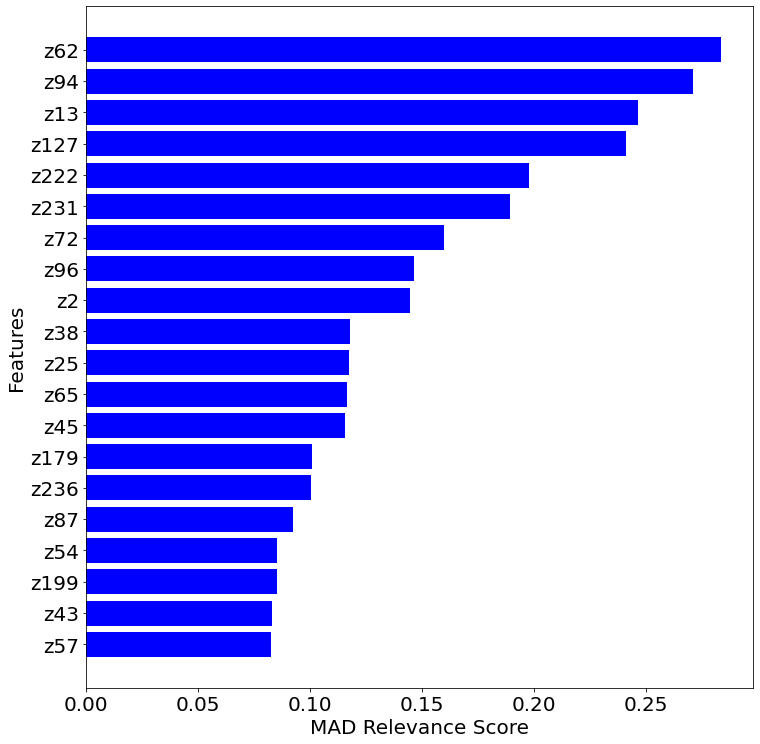

In [24]:
plotmaker(data = dresult_presoftmax_bkg, tags = tags, 
          plot_type = 'abs_bar', part_dataset = 'bkg', 
          save = False, modelnamesuffix = 'baseline_z')

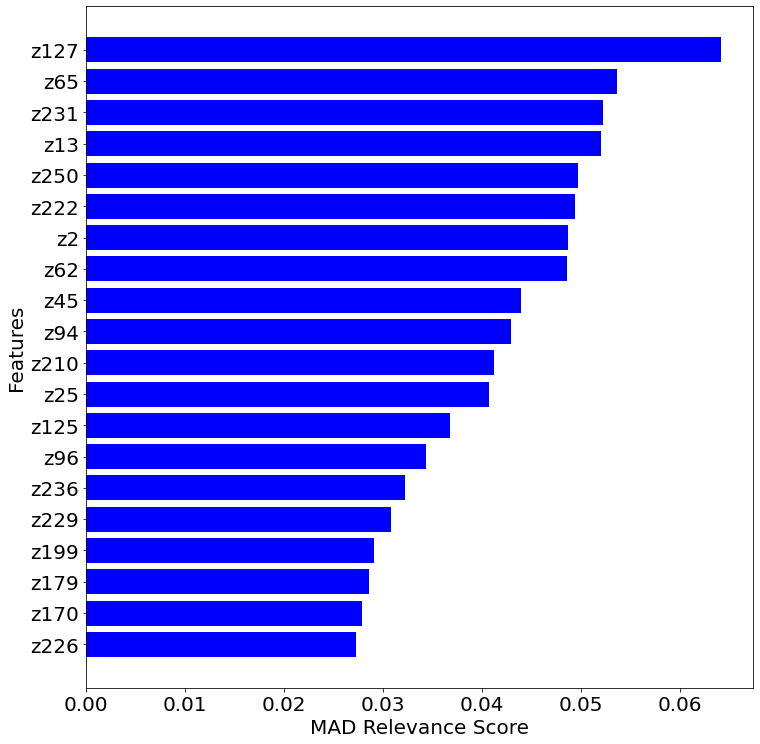

In [25]:
plotmaker(data = dresult_presoftmax_sig, tags = tags, 
          plot_type = 'abs_bar', part_dataset = 'sig', 
          save = False, modelnamesuffix = 'baseline_z')

/tmp/ipykernel_172757/1707122407.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,8))


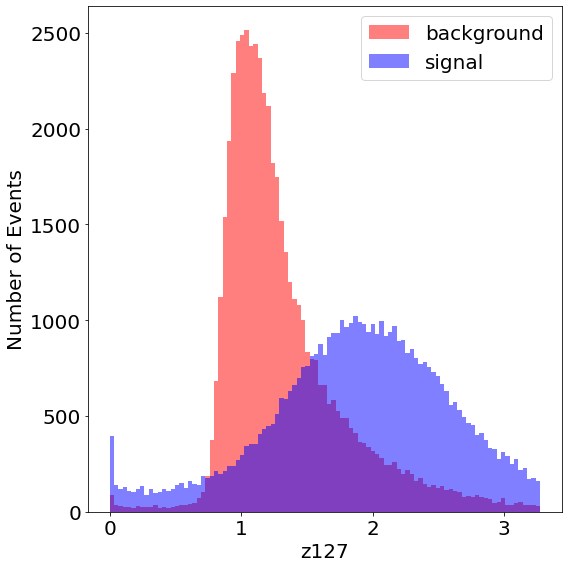

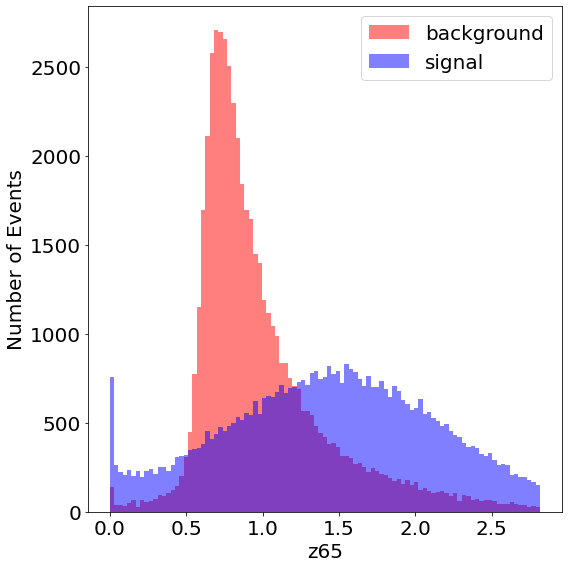

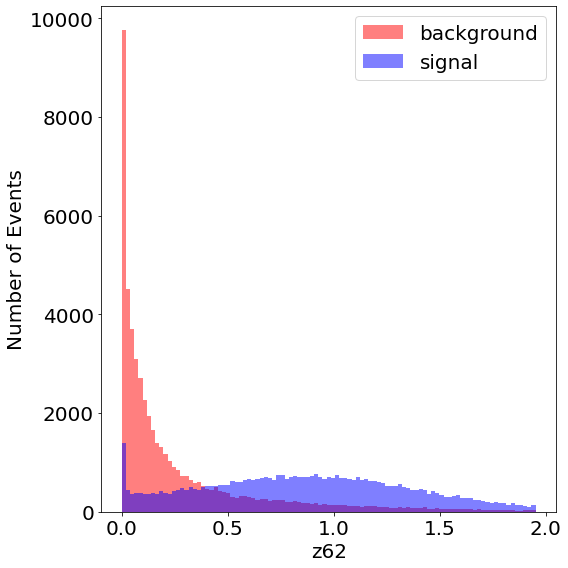

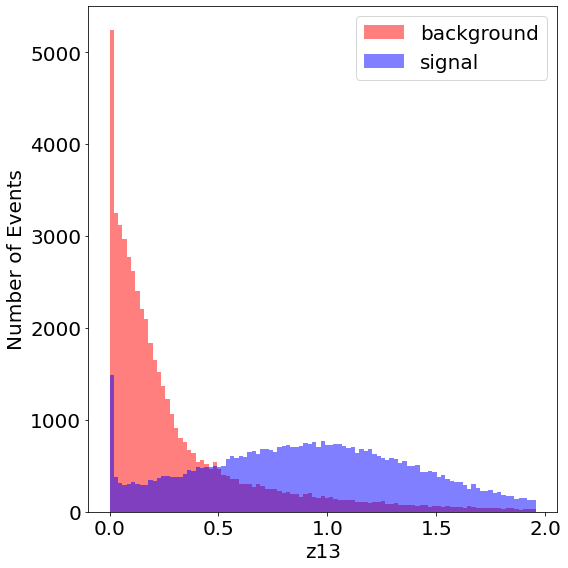

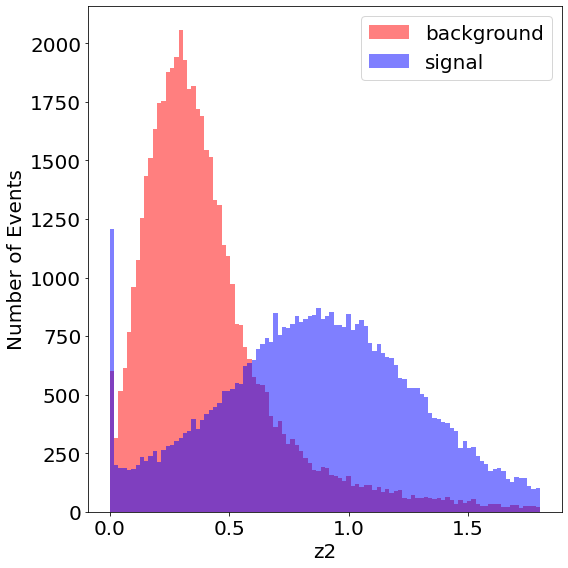

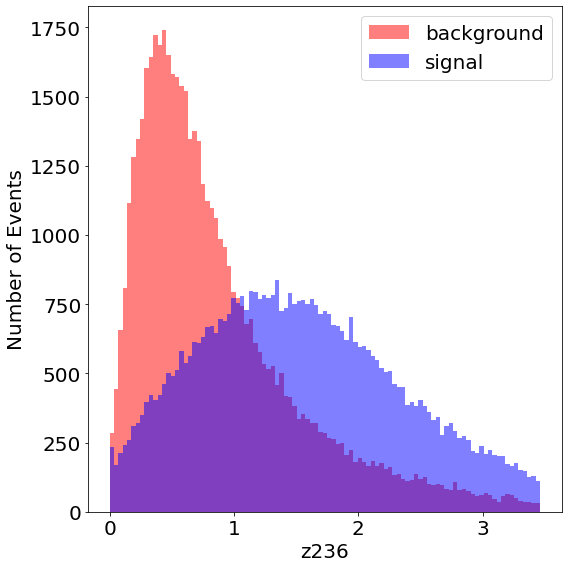

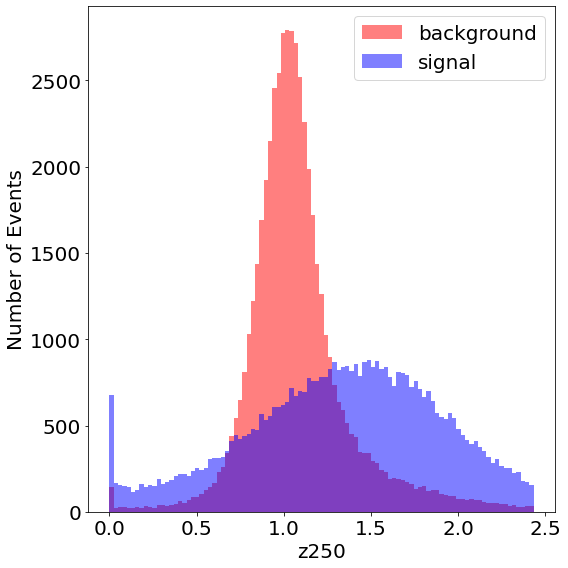

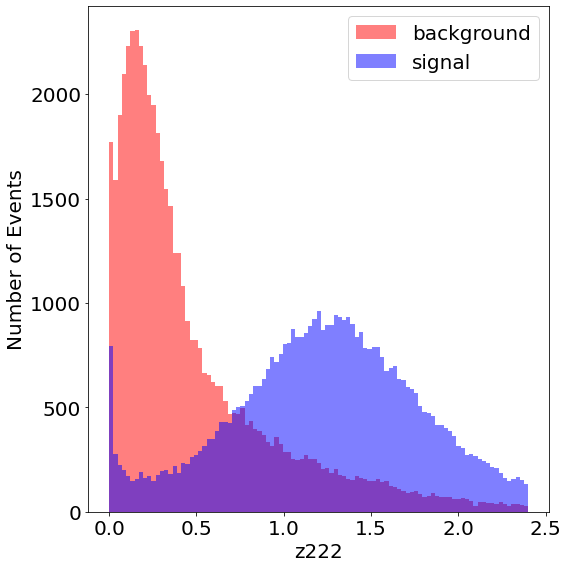

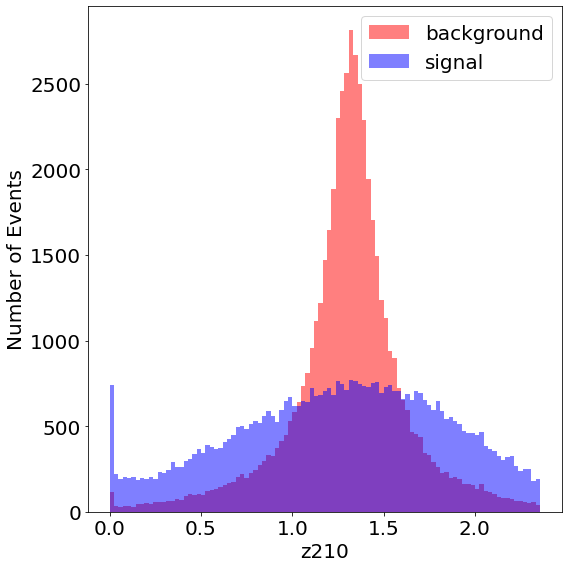

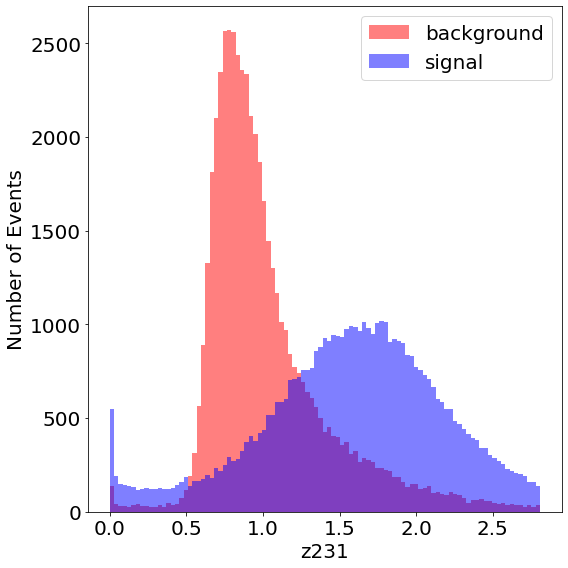

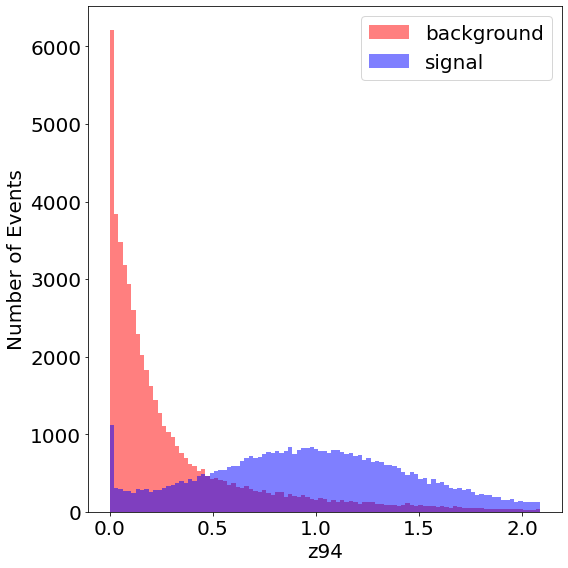

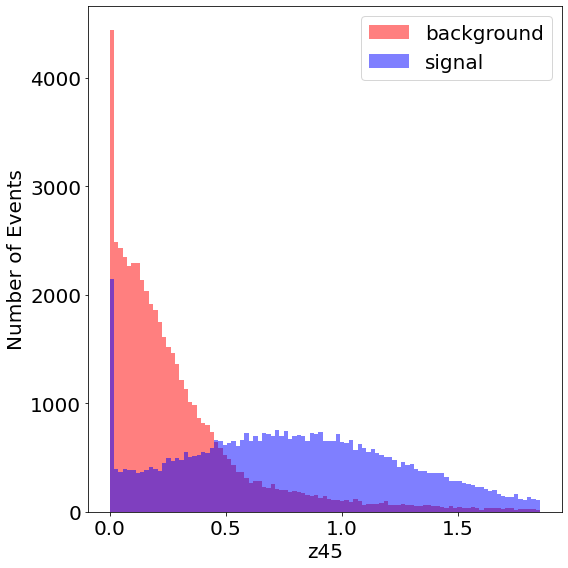

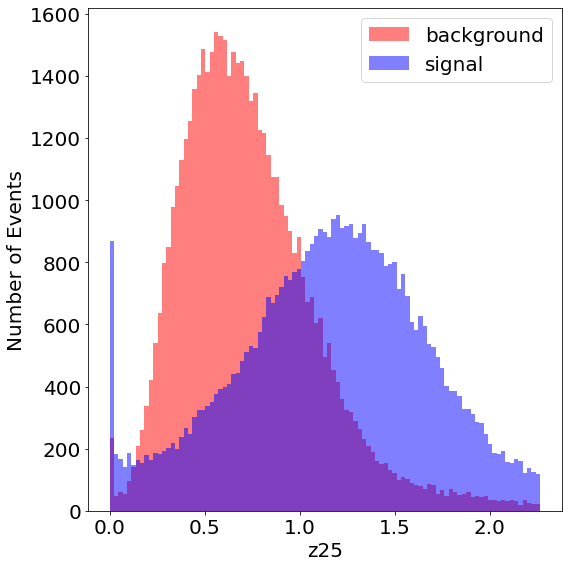

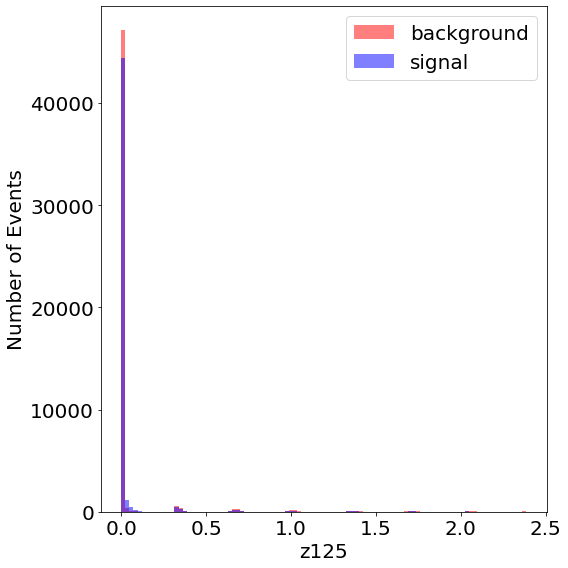

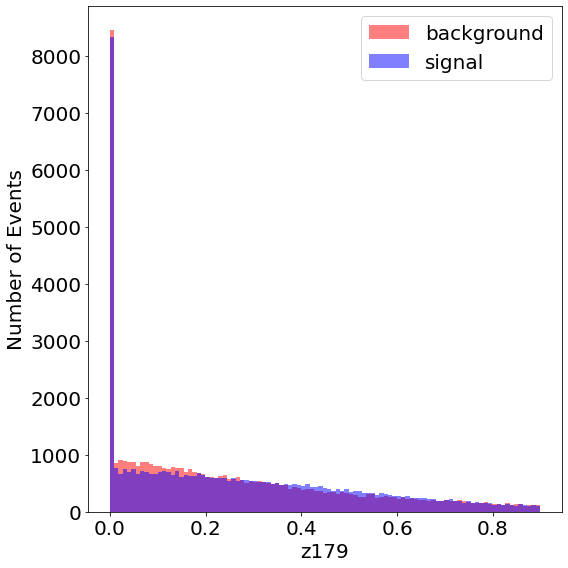

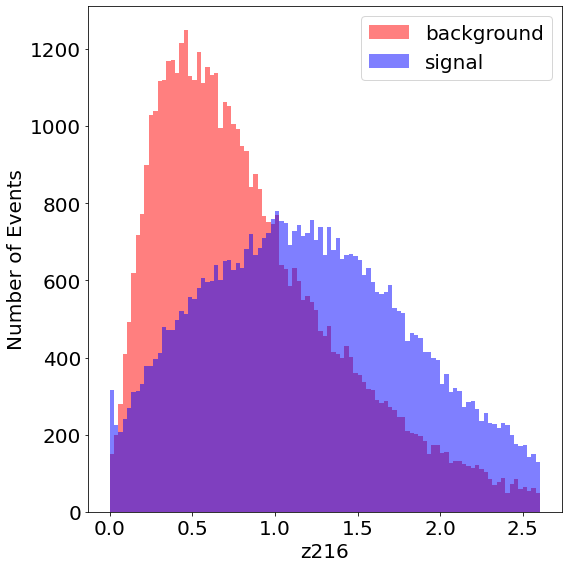

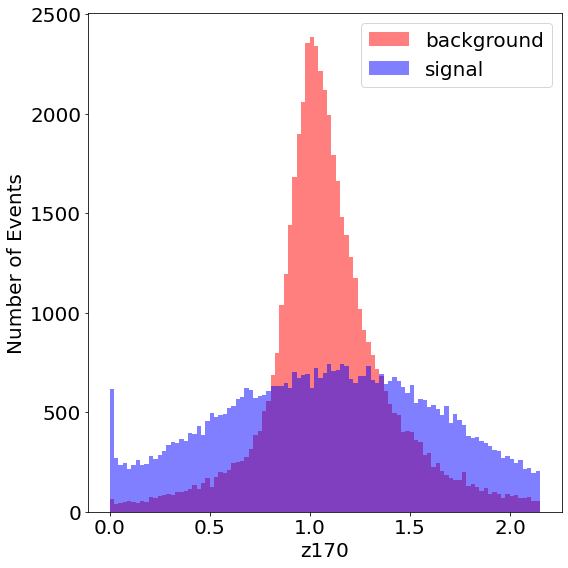

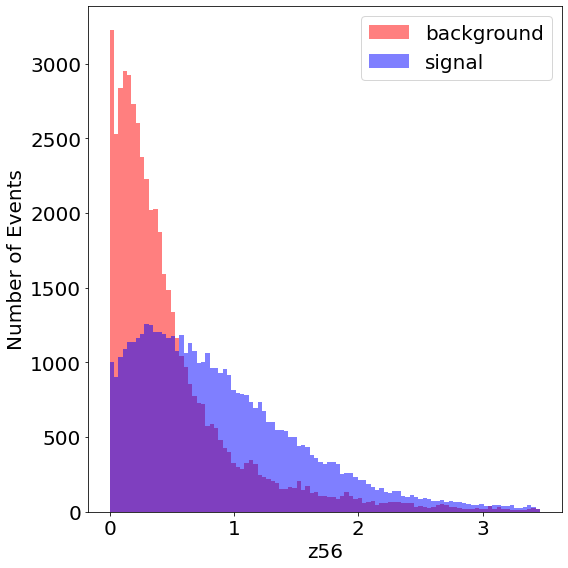

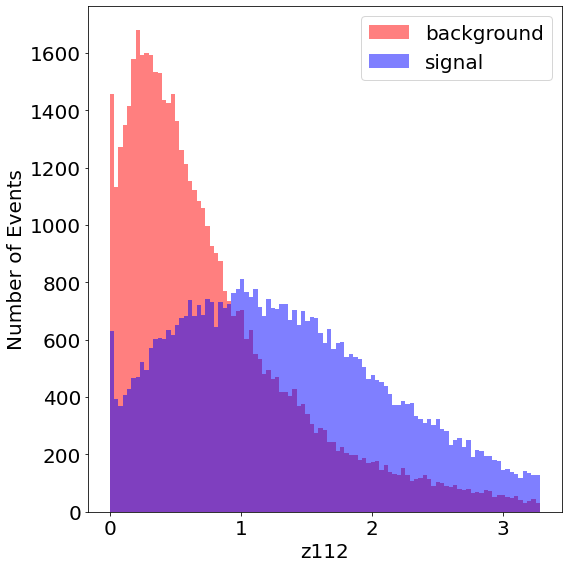

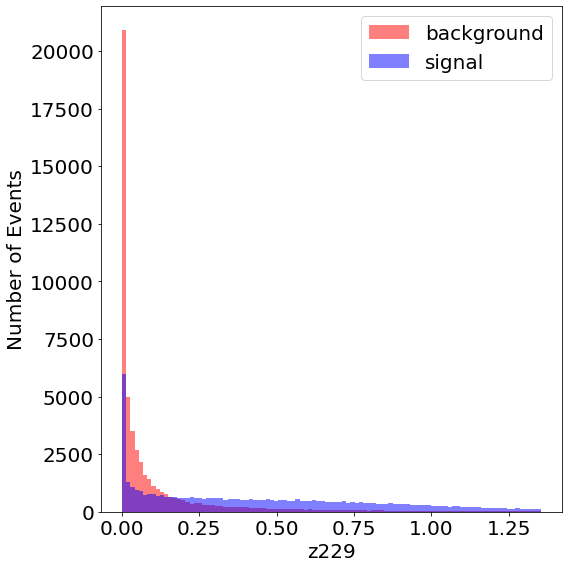

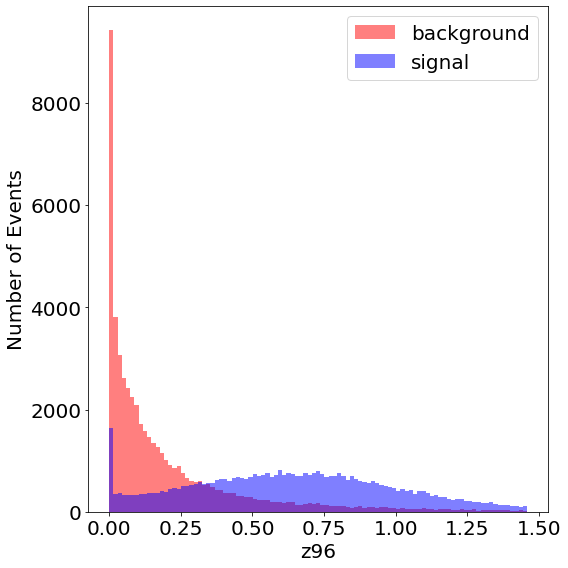

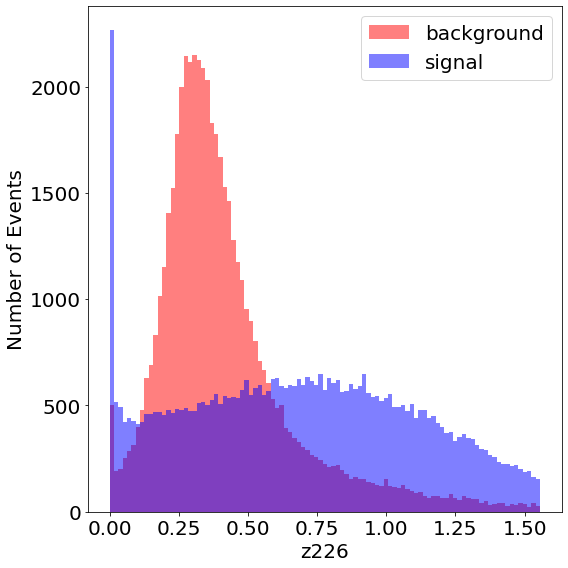

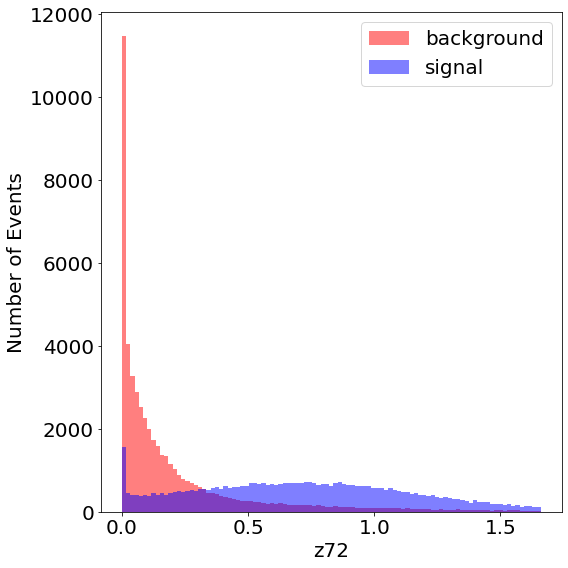

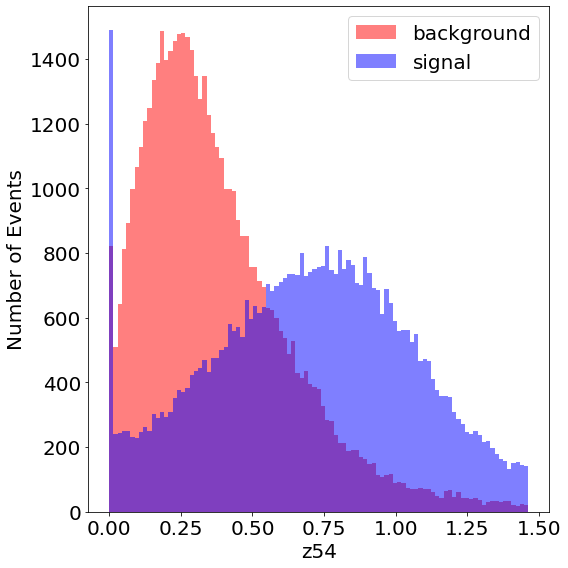

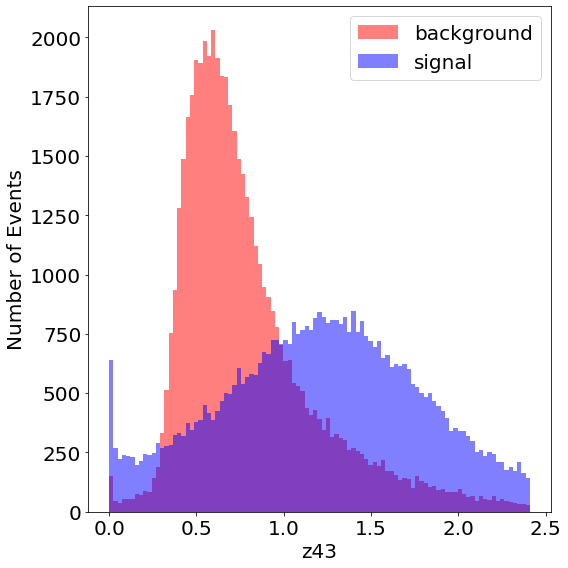

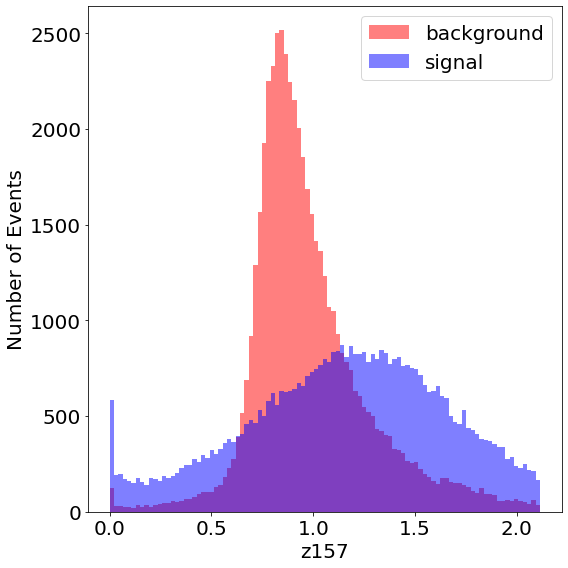

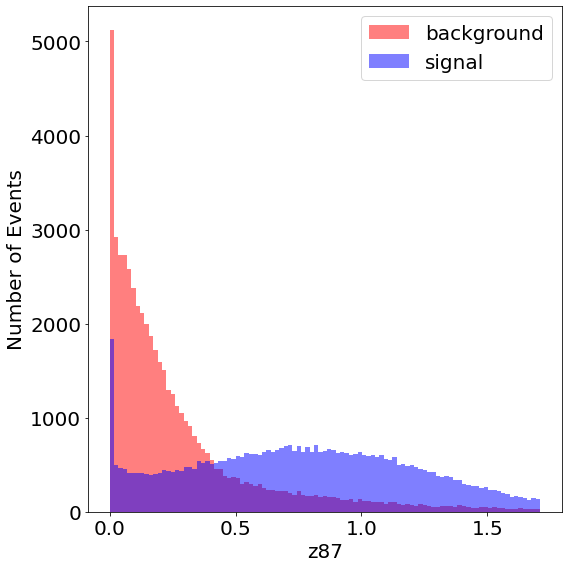

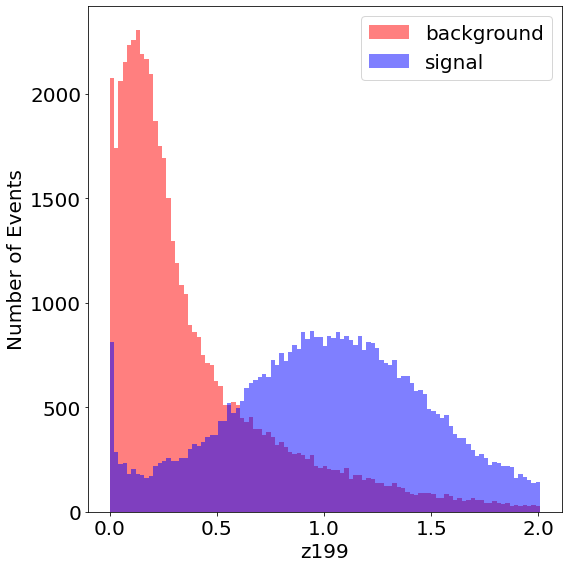

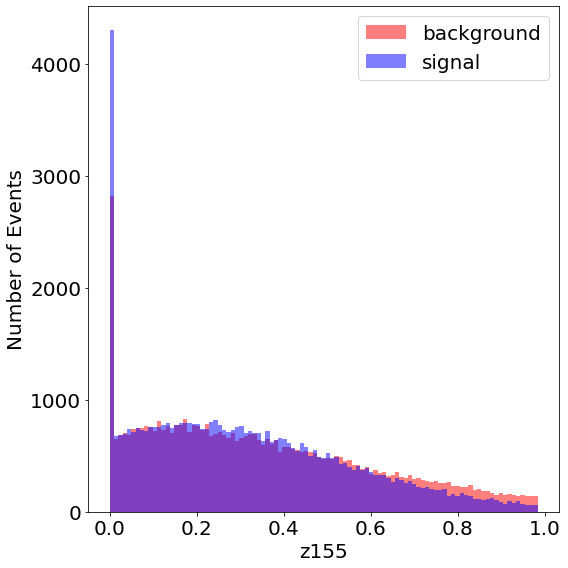

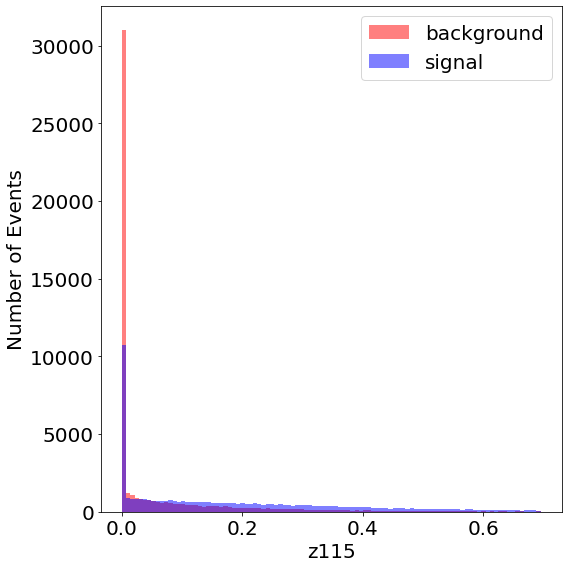

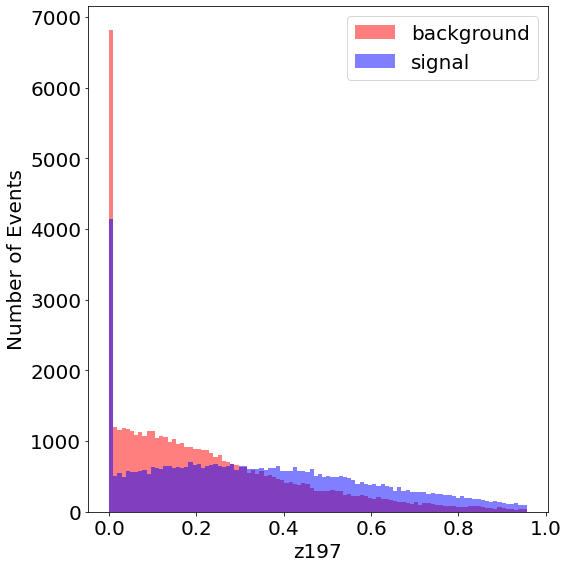

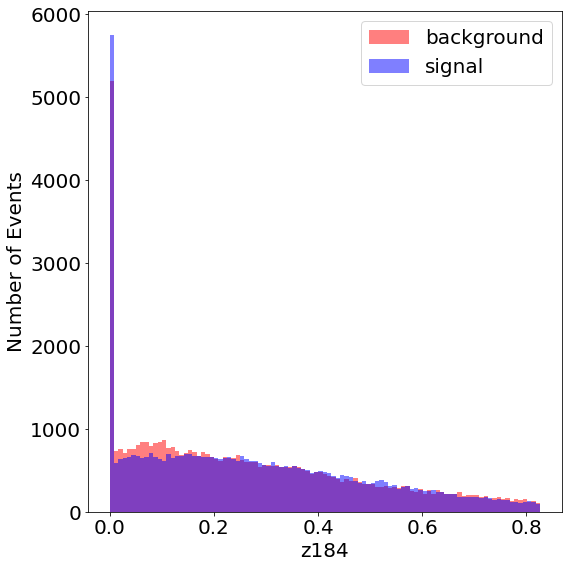

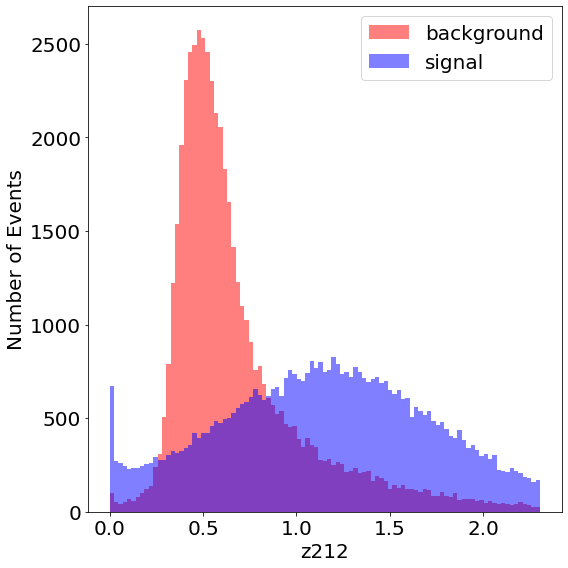

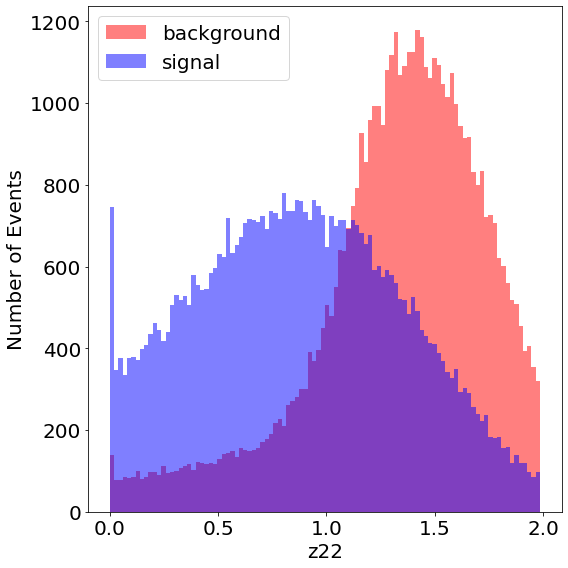

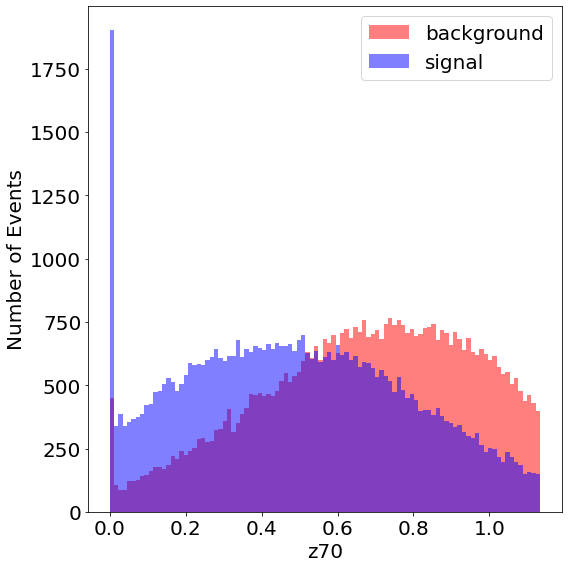

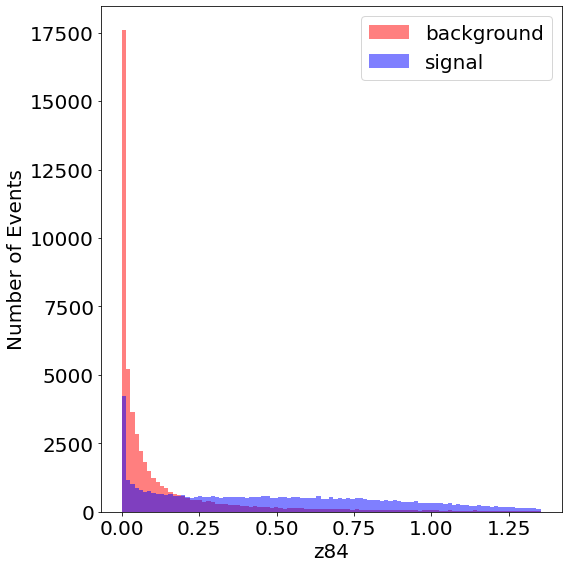

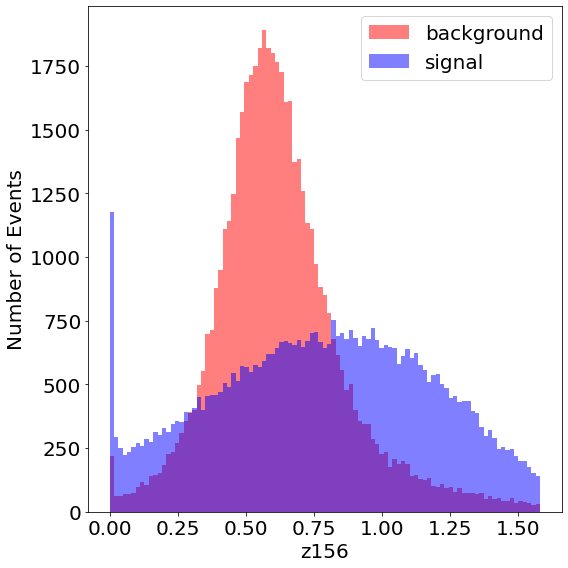

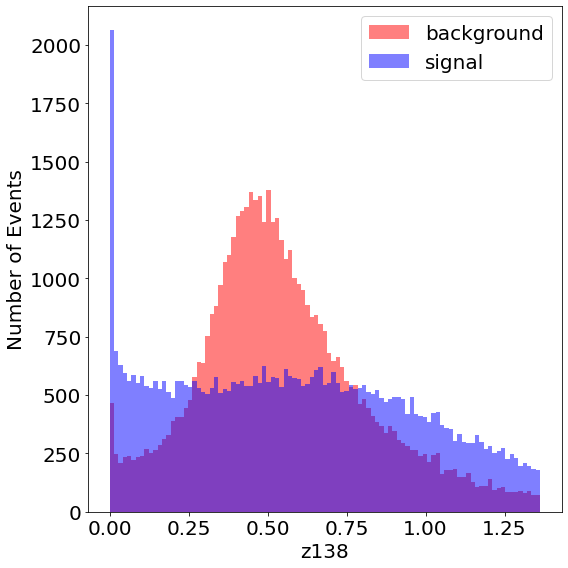

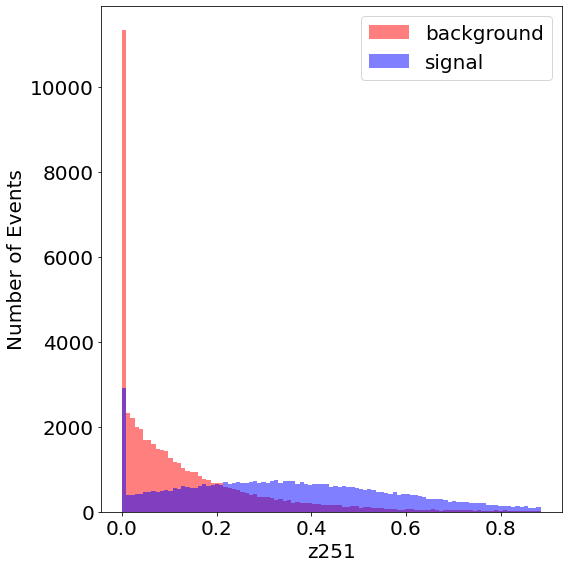

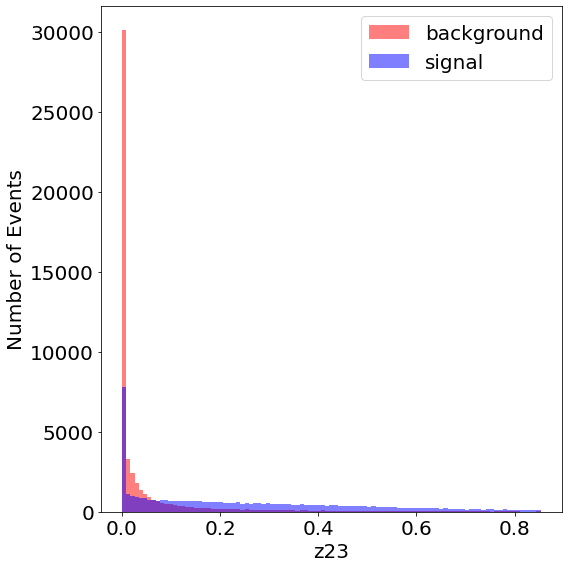

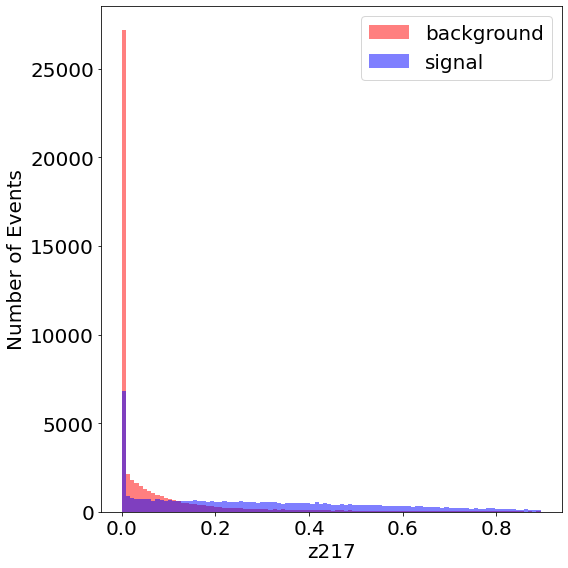

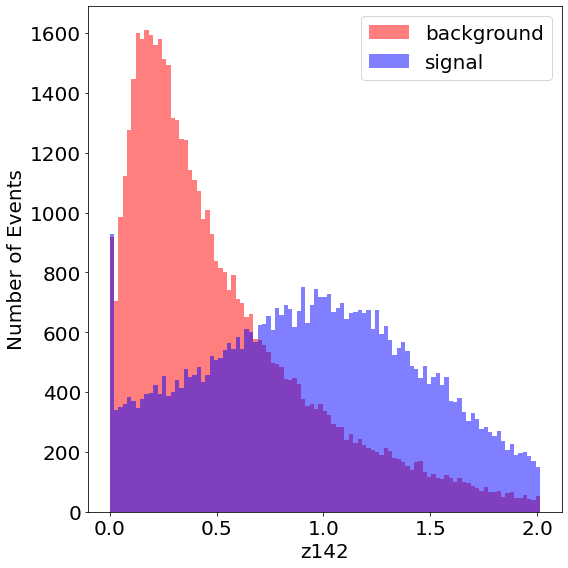

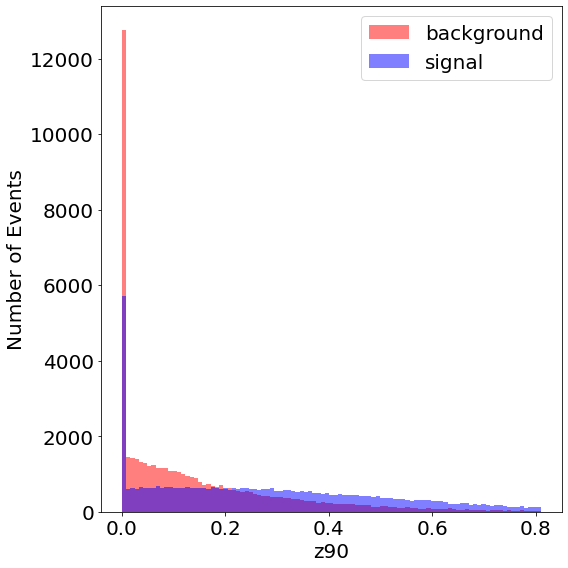

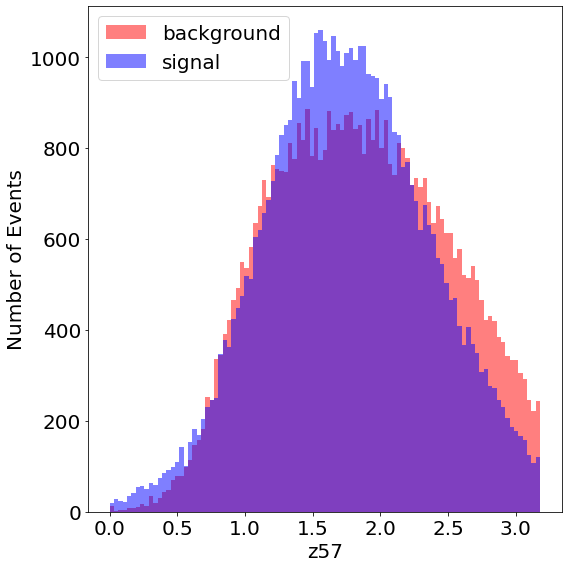

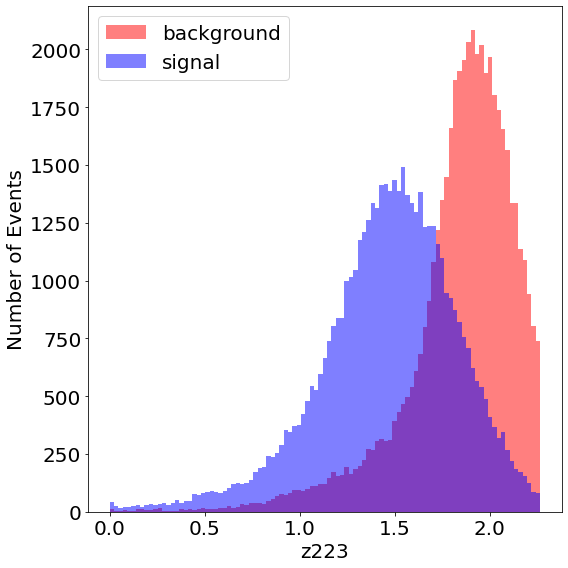

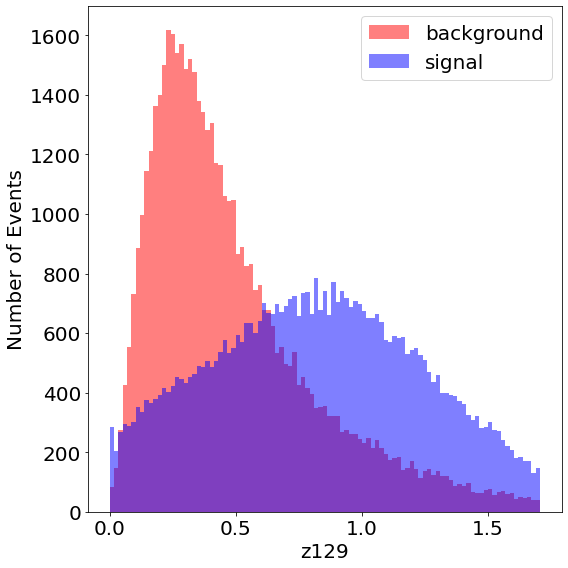

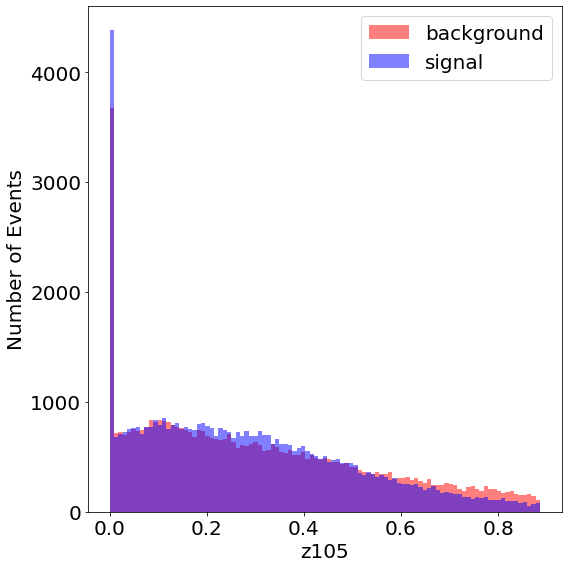

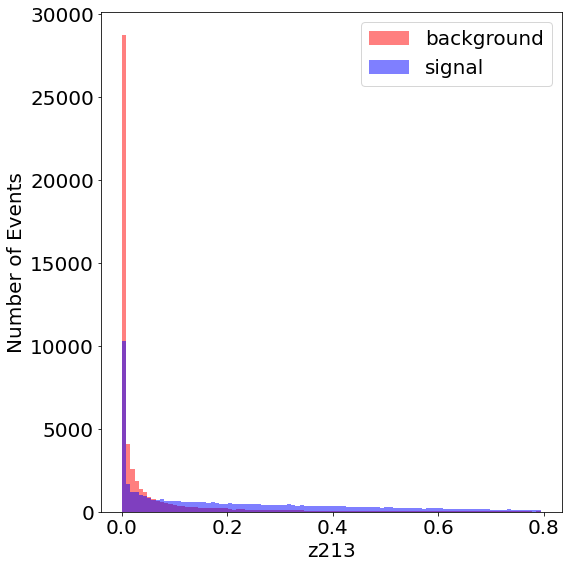

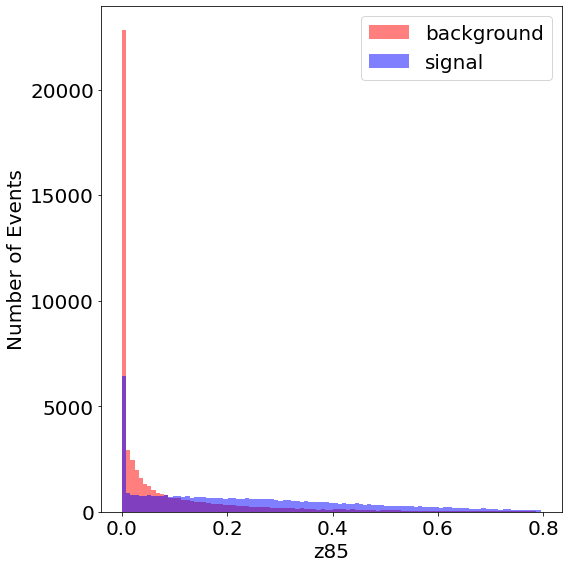

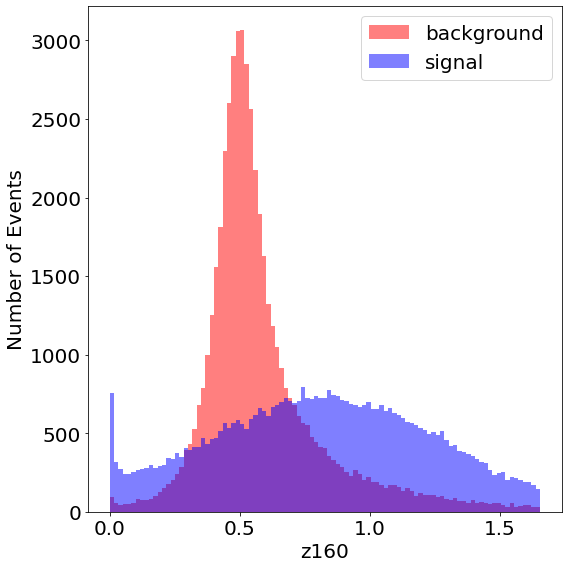

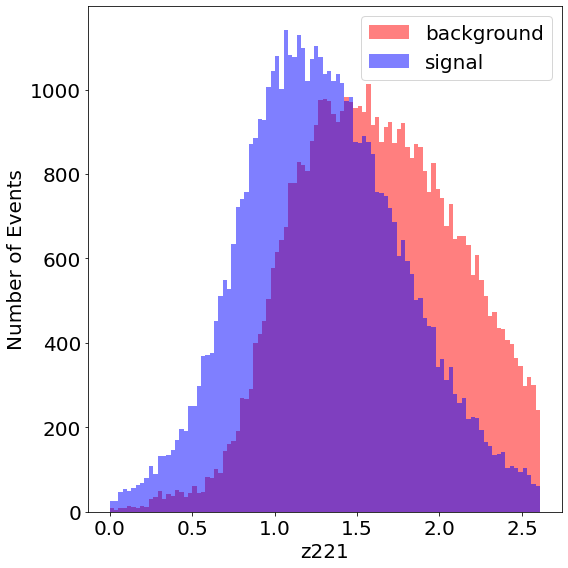

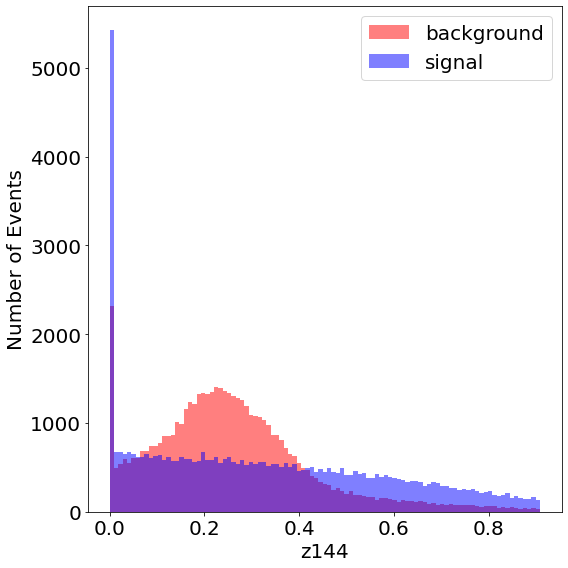

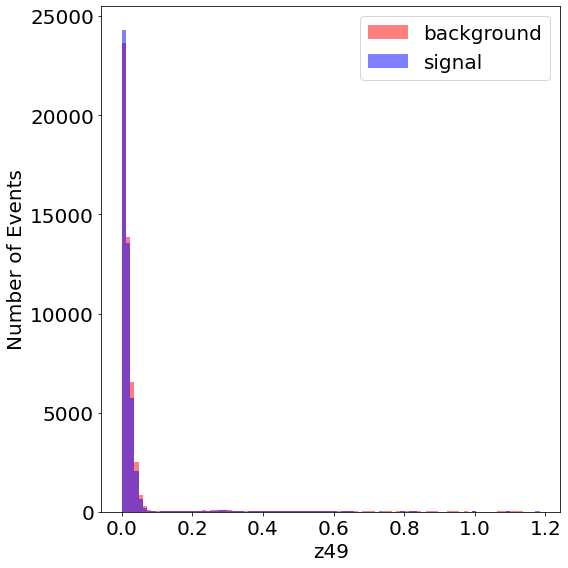

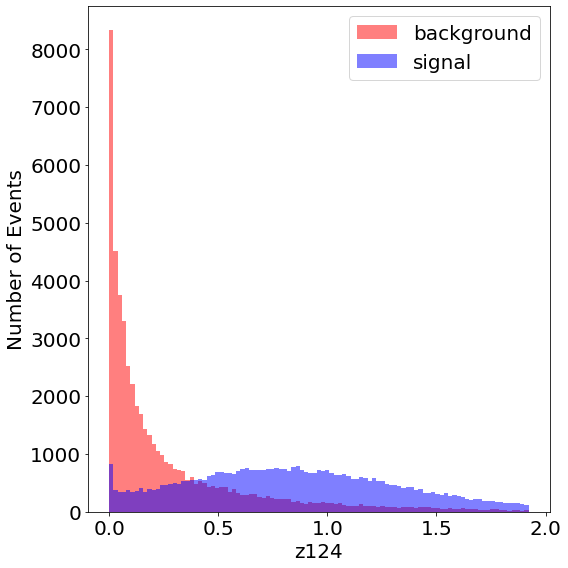

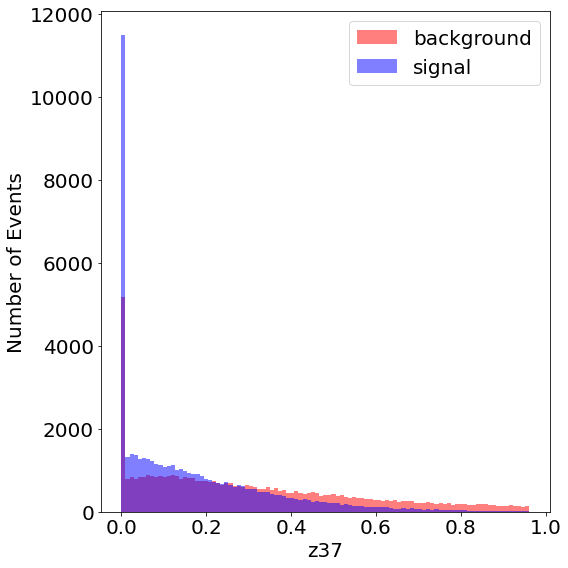

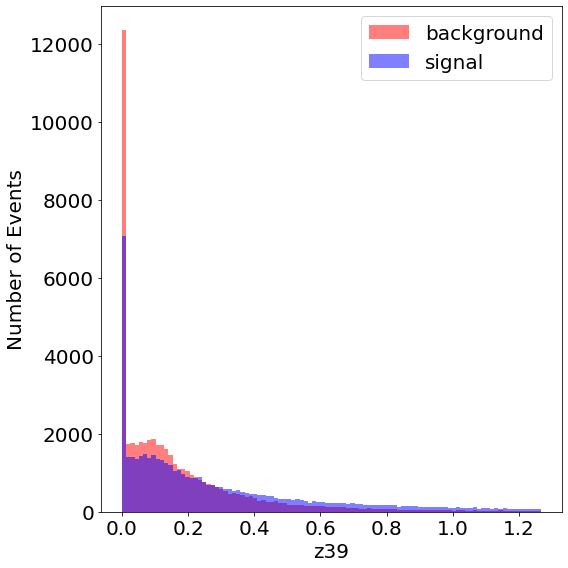

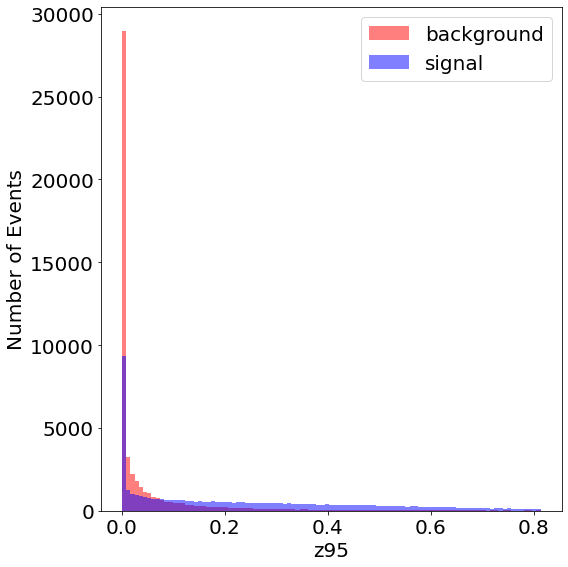

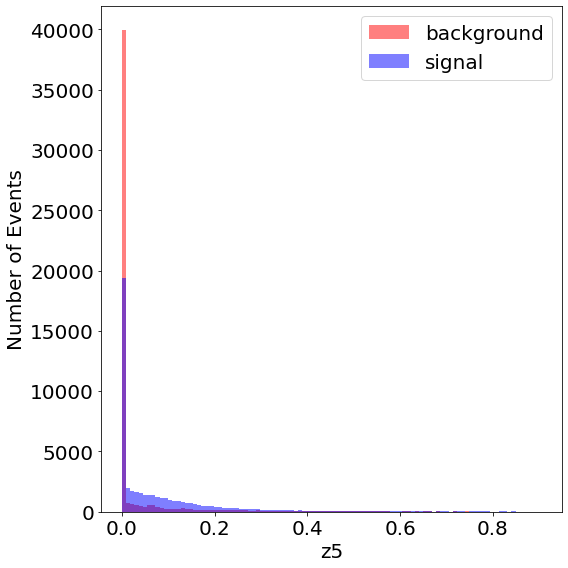

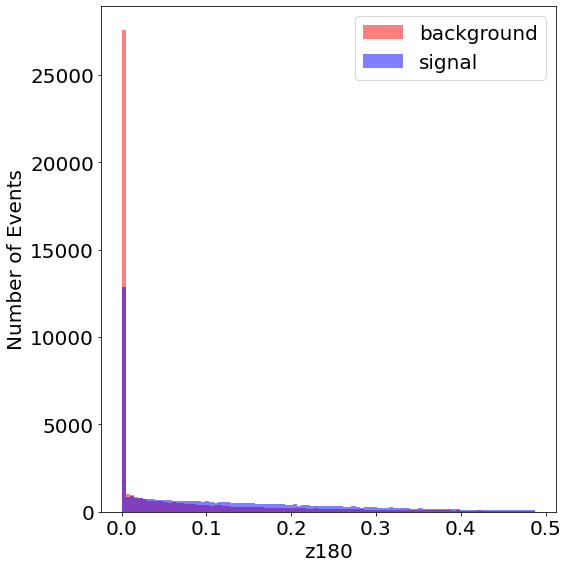

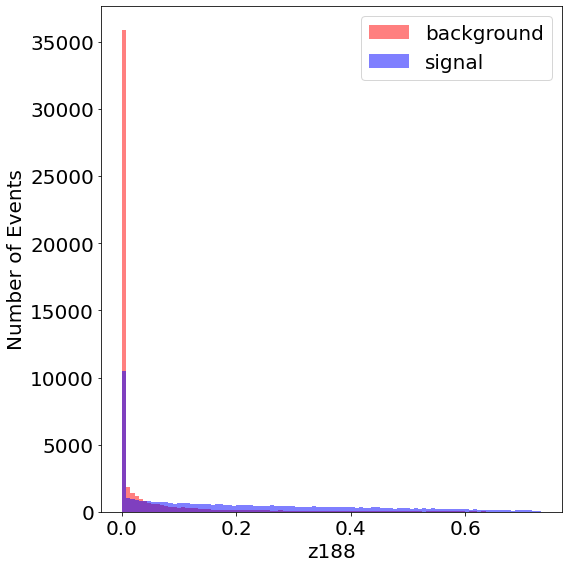

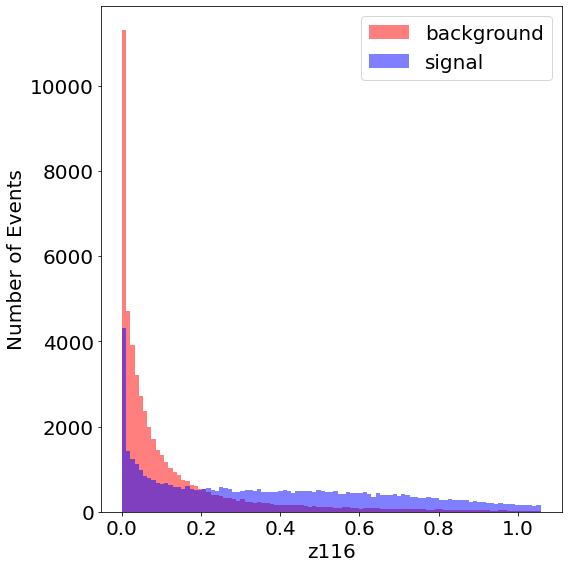

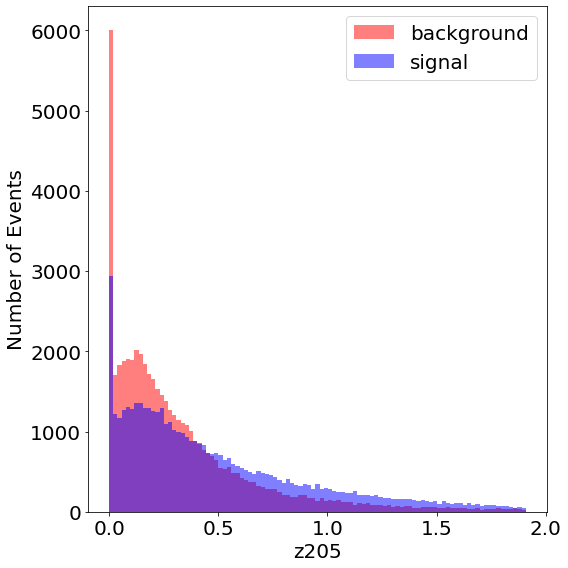

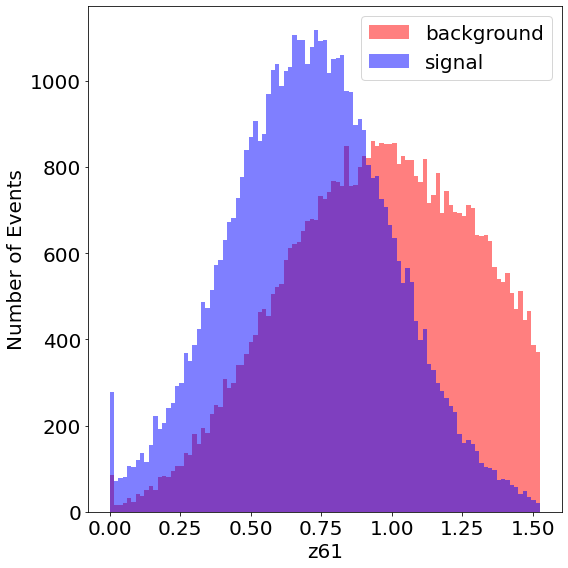

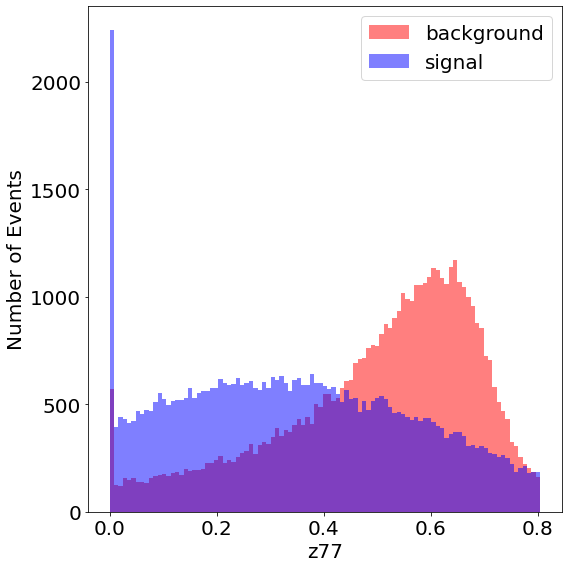

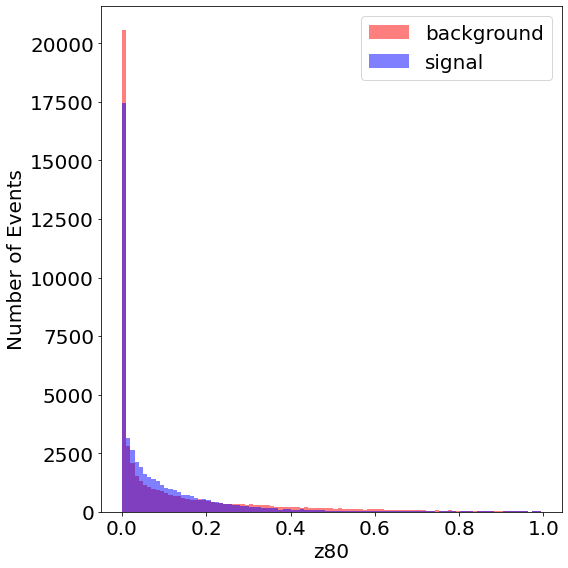

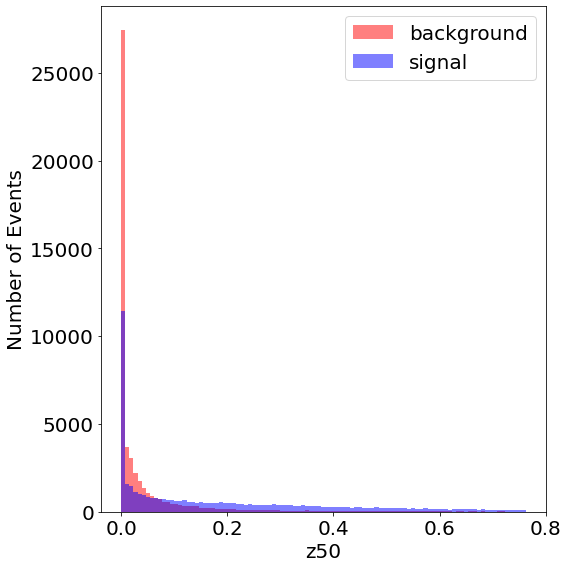

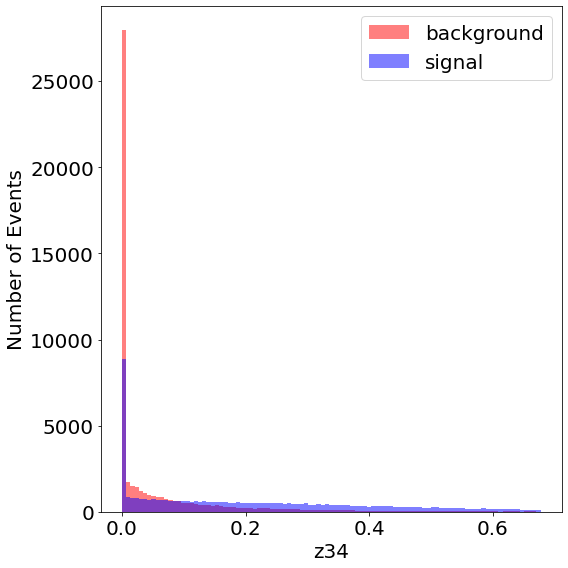

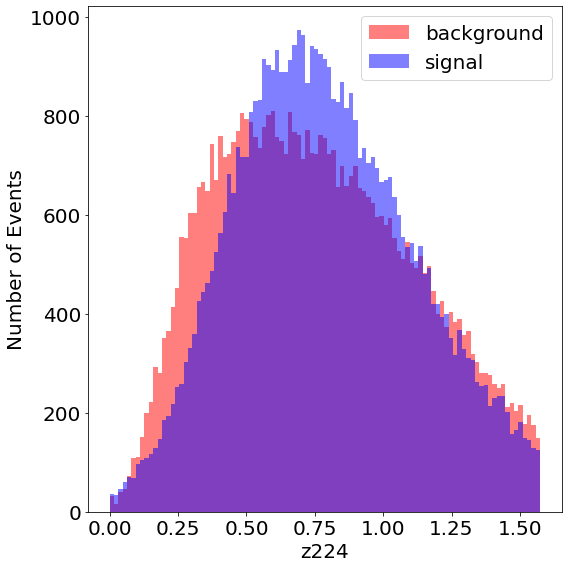

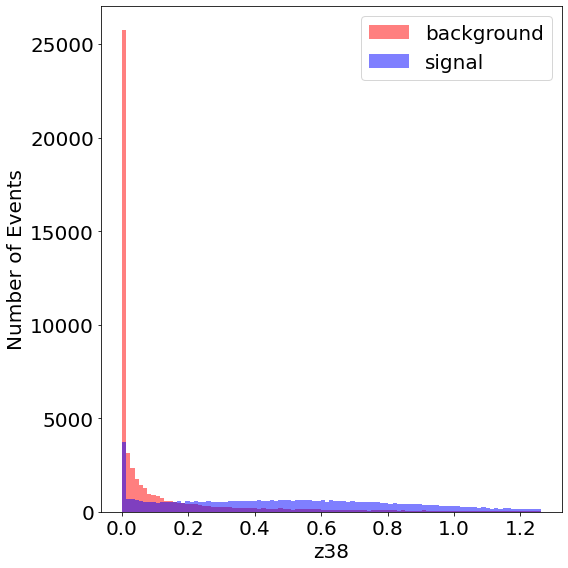

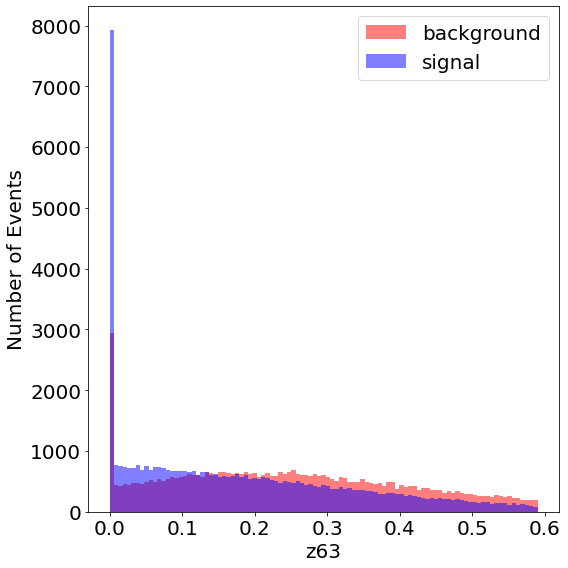

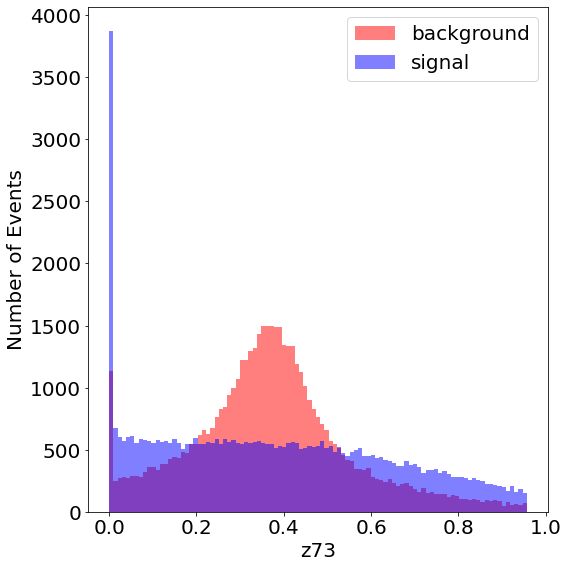

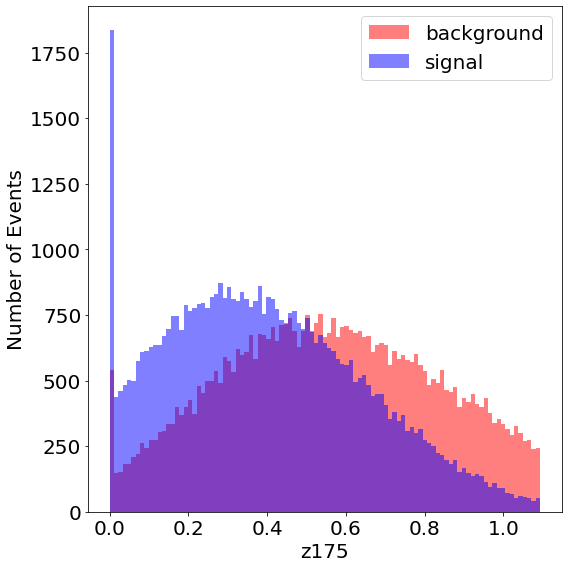

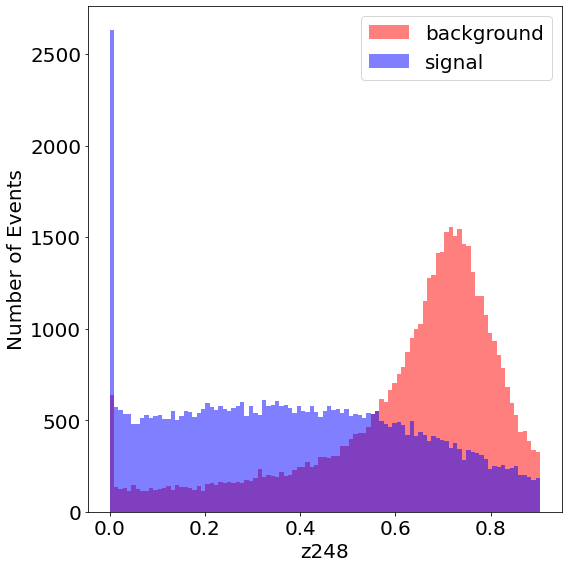

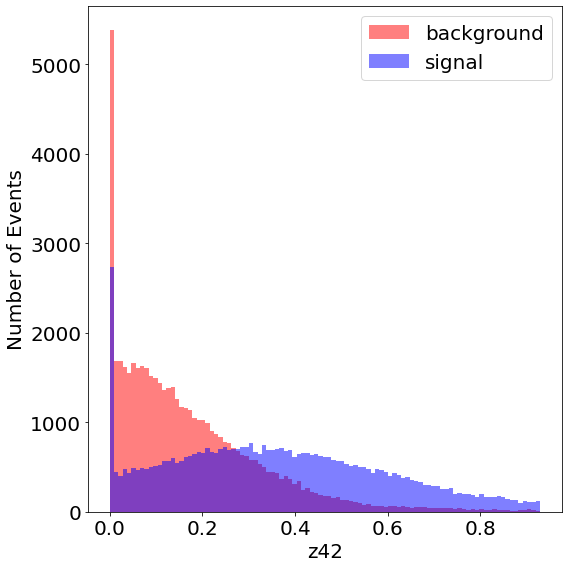

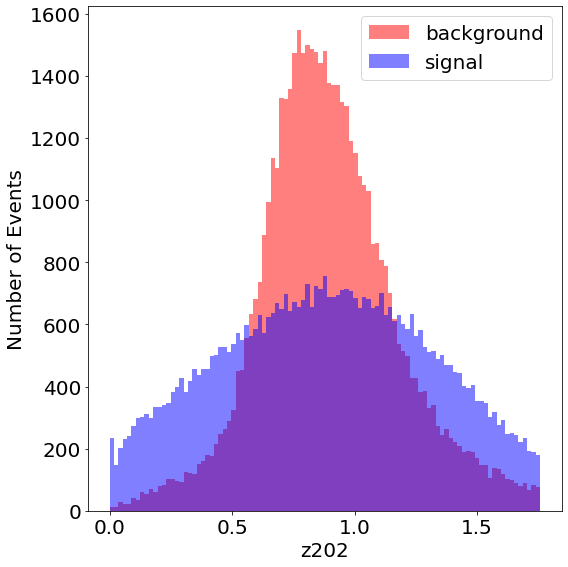

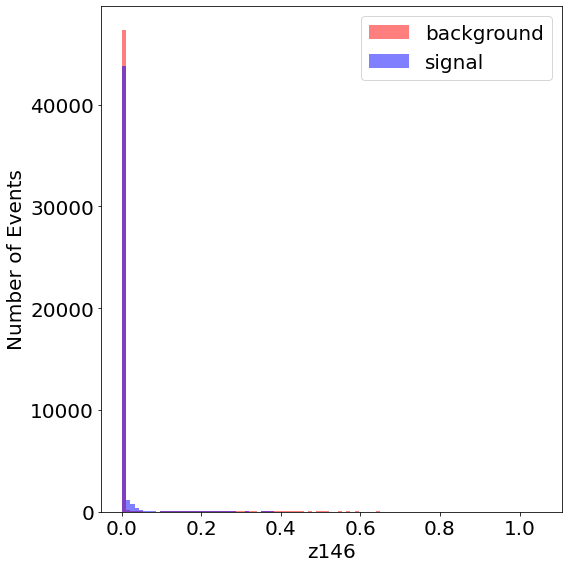

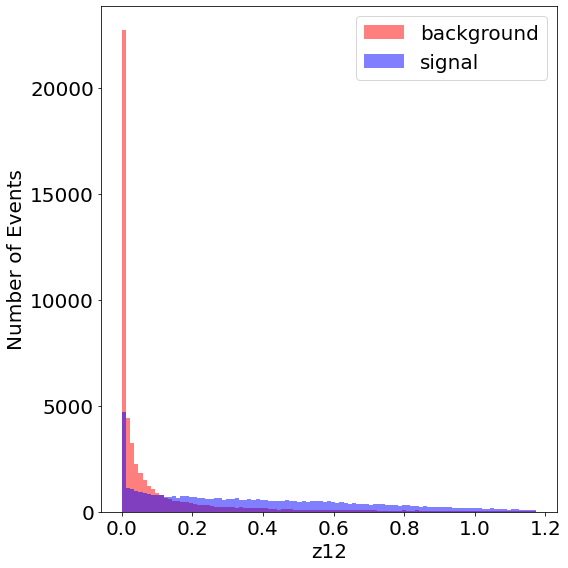

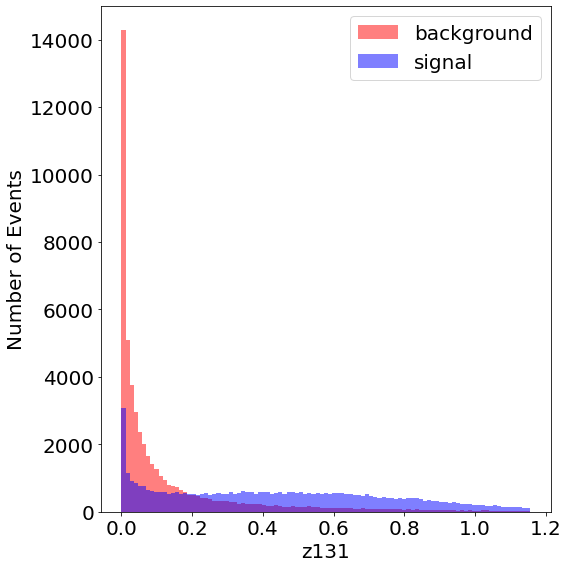

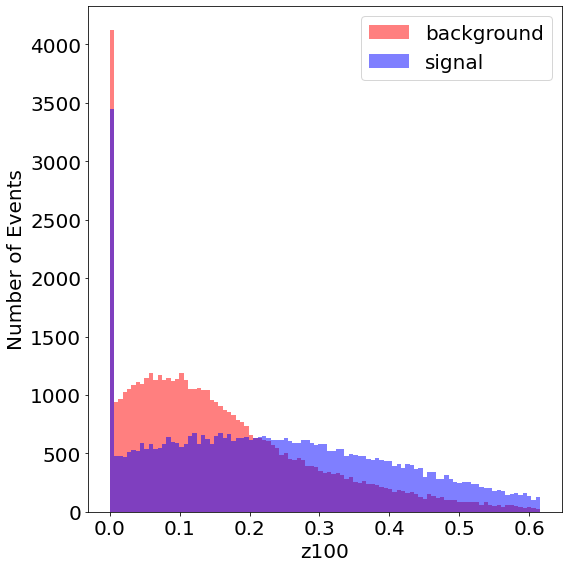

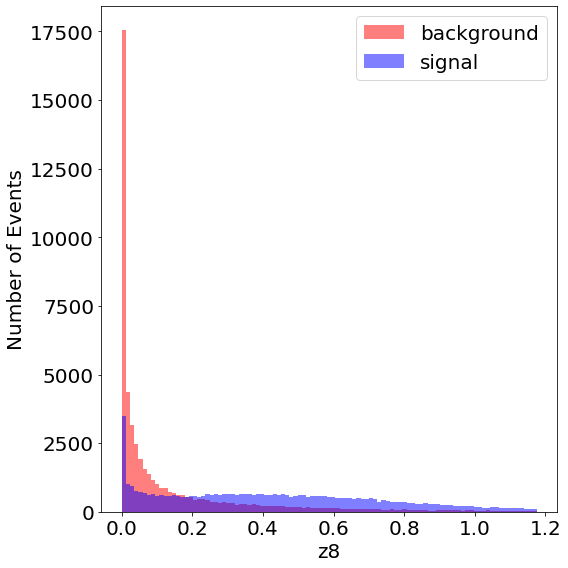

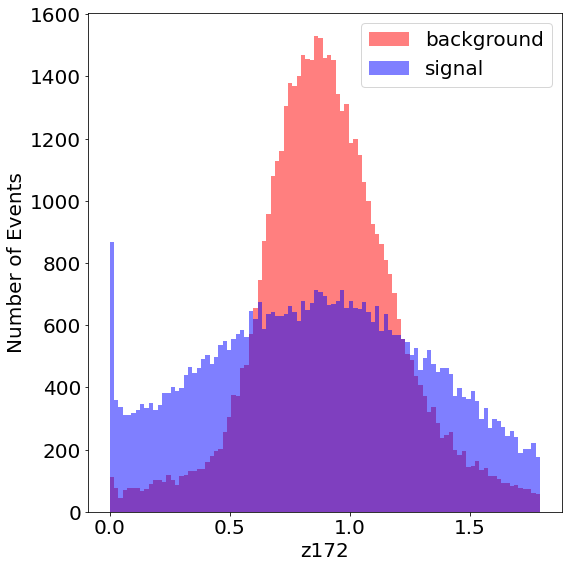

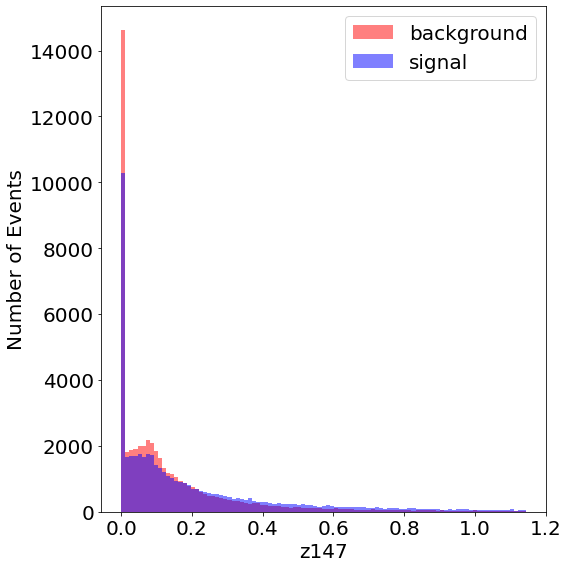

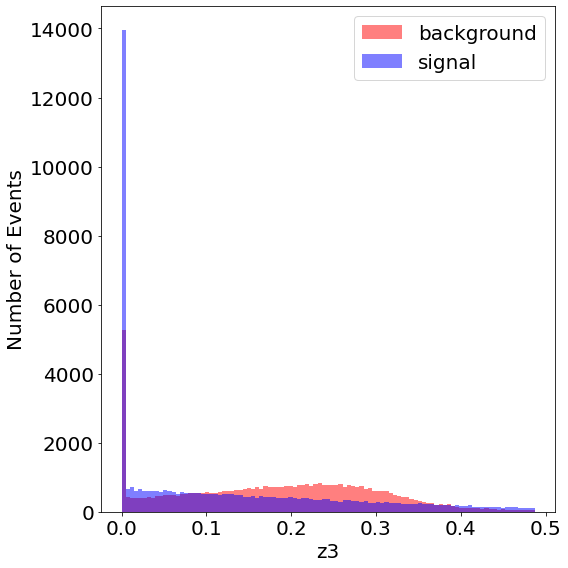

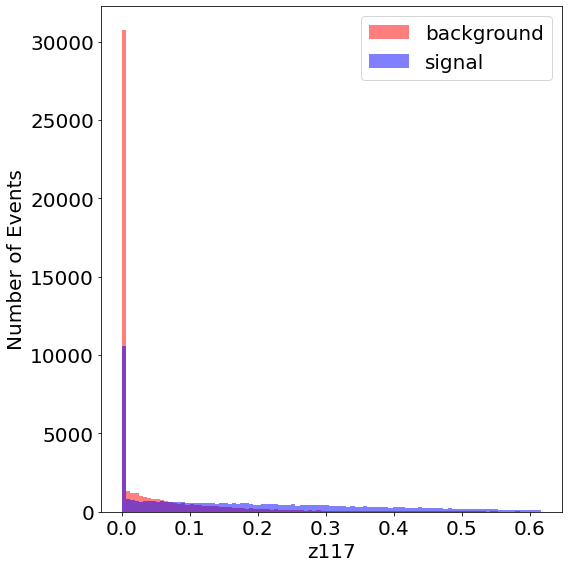

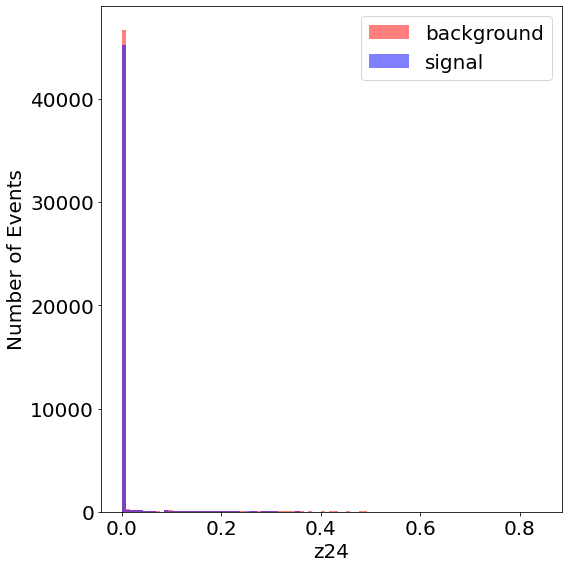

In [26]:
for ii, col in enumerate(sorted_tags):
    plt.figure(figsize=(8,8))
    #m = np.percentile(np.append(np.array(df_bkg[col]), np.array(df_sig[col])), 95)
    m = max(np.percentile(np.array(df_sig[col]), 95),
            np.percentile(np.array(df_bkg[col]), 95))
    plt.hist(df_bkg[col], bins=np.arange(0,m,m/100), label='background', color='red', alpha=0.5)
    plt.hist(df_sig[col], bins=np.arange(0,m,m/100), label='signal', color='blue', alpha=0.5)
    plt.xlabel(col, fontsize=20)
    plt.ylabel("Number of Events", fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(fontsize = 20)
    plt.tight_layout()
#     plt.savefig("figures/latent_dists_baseline/{}.pdf".format(col))

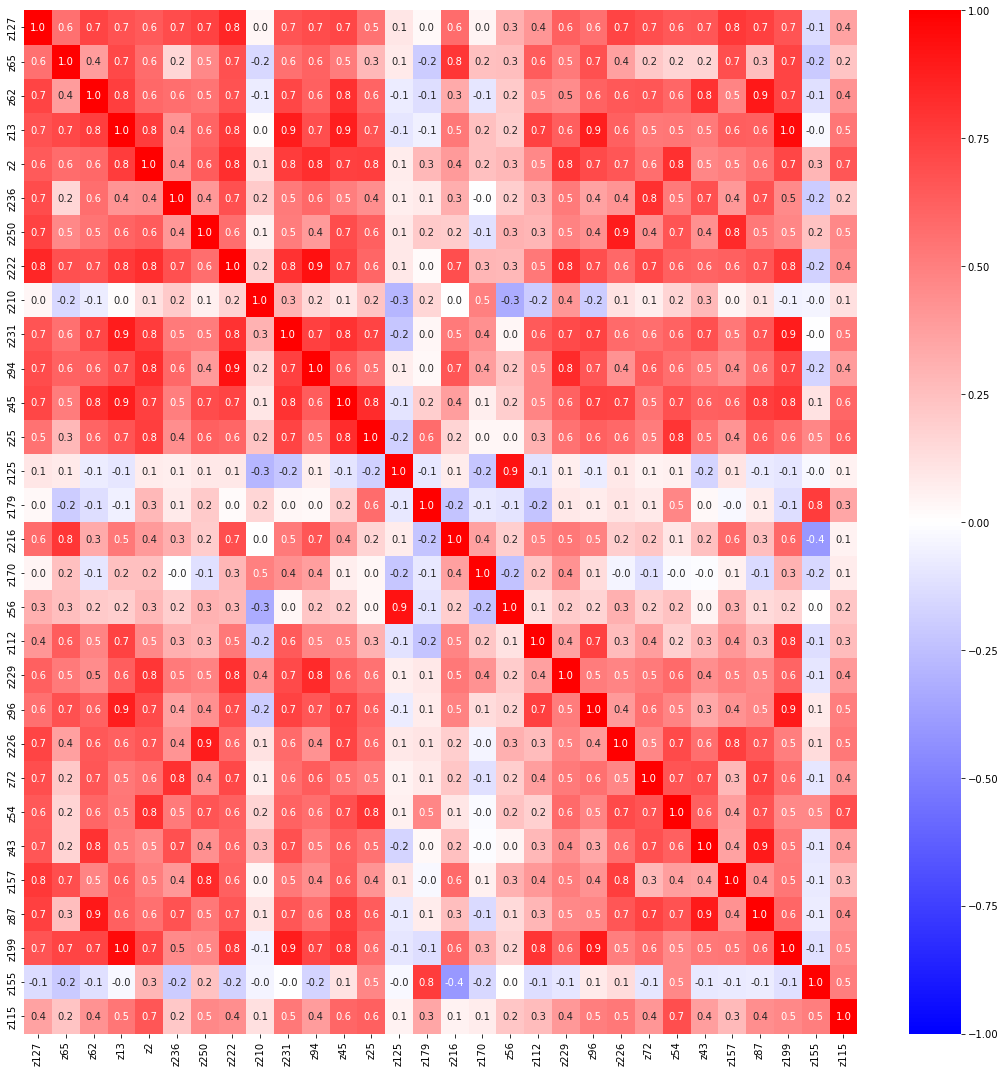

In [27]:
plt.figure(idx, figsize=(15,15))
bkg_corrmat = df_bkg.corr()
#sorted_ = bkg_corrmat.abs().sum(0).sort_values(ascending=False).keys()
sorted_ = bkg_corrmat.columns
bkg_corrmat = bkg_corrmat.loc[sorted_[:30], sorted_[:30]]
sns.heatmap(bkg_corrmat, center=0, annot=True, cmap='bwr', fmt='.1f', vmin= -1., vmax = 1.)
plt.tight_layout()
# plt.savefig("figures/LatentSpaceFeatCorr_PFN_baseline_bkg.pdf")

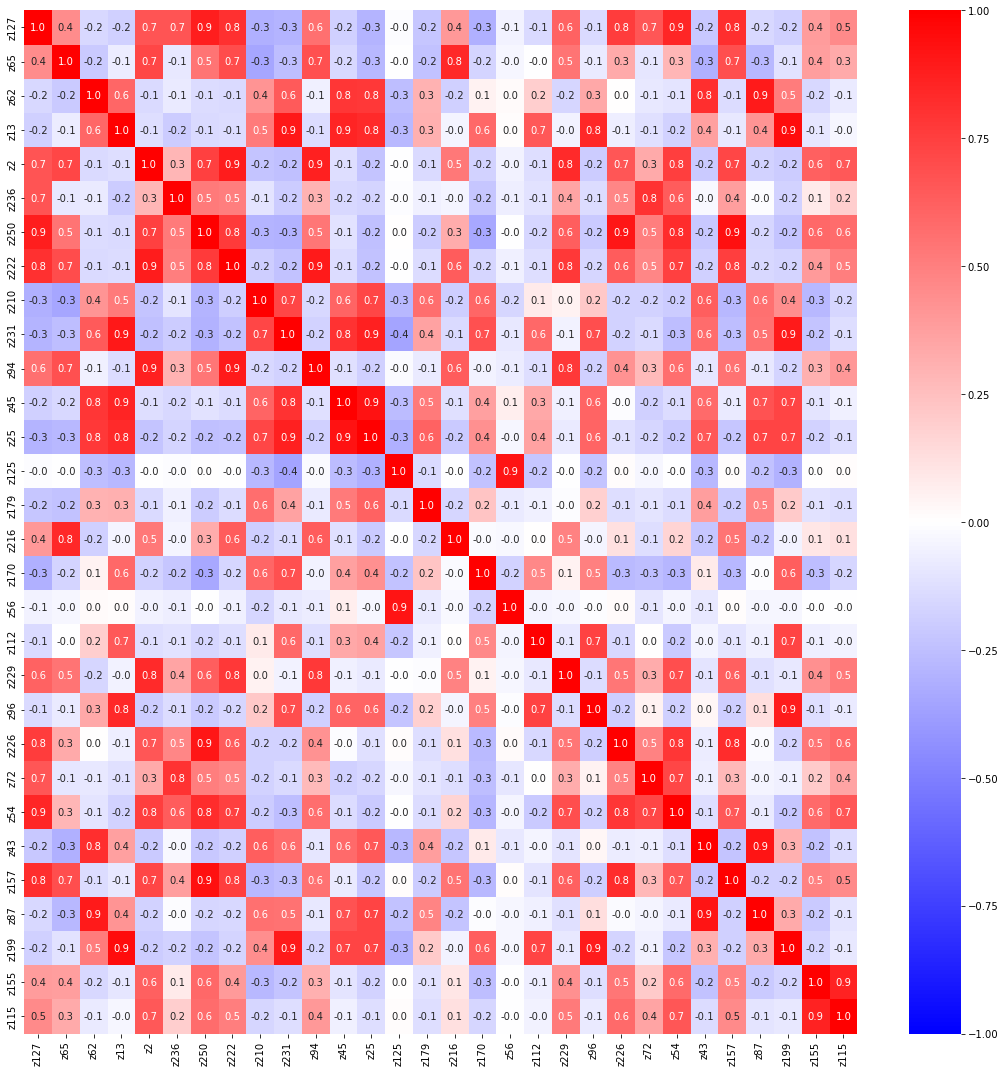

In [28]:
plt.figure(idx, figsize=(15,15))
sig_corrmat = df_sig.corr()
# sorted_ = sig_corrmat.abs().sum(0).sort_values(ascending=False).keys()
sorted_ = sig_corrmat.columns
sig_corrmat = sig_corrmat.loc[sorted_[:30], sorted_[:30]]
sns.heatmap(sig_corrmat, center=0, annot=True, cmap='bwr', fmt='.1f',vmin= -1., vmax = 1.)
plt.tight_layout()
# plt.savefig("figures/LatentSpaceFeatCorr_PFN_baseline_sig.pdf")

In [29]:
d_mean

tensor([[ 2.5371e-01,  9.0582e-05, -3.7691e-06],
        [ 1.4129e-01,  2.3102e-04, -1.2295e-03],
        [ 9.3876e-02,  1.2682e-04, -5.2080e-04],
        [ 6.8496e-02,  1.3051e-04, -2.4357e-03],
        [ 5.2960e-02,  1.8955e-05, -7.6665e-04],
        [ 4.2543e-02,  1.0714e-04, -1.0888e-03],
        [ 3.5173e-02,  1.7920e-04, -2.0304e-03],
        [ 2.9741e-02,  1.8693e-04,  5.8627e-05],
        [ 2.5638e-02, -3.5747e-04,  1.3083e-04],
        [ 2.2413e-02, -6.1193e-04, -7.5528e-04],
        [ 1.9806e-02, -1.0431e-04, -1.3676e-03],
        [ 1.7659e-02,  3.3208e-04, -1.4877e-03],
        [ 1.5864e-02, -4.9217e-04, -1.4705e-03],
        [ 1.4335e-02,  1.9567e-04, -2.6472e-03],
        [ 1.3024e-02,  4.8659e-04, -1.3543e-03],
        [ 1.1894e-02, -1.9203e-04, -8.9275e-04],
        [ 1.0901e-02, -7.3992e-05, -2.7951e-04],
        [ 1.0033e-02,  1.7228e-04,  3.2972e-04],
        [ 9.2650e-03, -6.2123e-05, -1.3888e-03],
        [ 8.5831e-03,  1.1767e-03, -1.7791e-03],
        [ 7.9739e-03

In [30]:
print(sorted_tags)

['z127', 'z65', 'z62', 'z13', 'z2', 'z236', 'z250', 'z222', 'z210', 'z231', 'z94', 'z45', 'z25', 'z125', 'z179', 'z216', 'z170', 'z56', 'z112', 'z229', 'z96', 'z226', 'z72', 'z54', 'z43', 'z157', 'z87', 'z199', 'z155', 'z115', 'z197', 'z184', 'z212', 'z22', 'z70', 'z84', 'z156', 'z138', 'z251', 'z23', 'z217', 'z142', 'z90', 'z57', 'z223', 'z129', 'z105', 'z213', 'z85', 'z160', 'z221', 'z144', 'z49', 'z124', 'z37', 'z39', 'z95', 'z5', 'z180', 'z188', 'z116', 'z205', 'z61', 'z77', 'z80', 'z50', 'z34', 'z224', 'z38', 'z63', 'z73', 'z175', 'z248', 'z42', 'z202', 'z146', 'z12', 'z131', 'z100', 'z8', 'z172', 'z147', 'z3', 'z117', 'z24']
